# Subject-Specific Feature Extraction

This notebook extracts distinctive stylistic features, topics, and n-grams for each subject independently.
We're not comparing real vs fake news - just analyzing what makes each subject's writing style unique.

## Approach:
1. Load all articles (real and fake combined) per subject
2. Extract comprehensive stylistic features for each subject
3. Perform topic modeling per subject
4. Extract distinctive n-grams per subject
5. Identify the most characteristic features for each subject

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
from collections import Counter, defaultdict
import warnings
warnings.filterwarnings('ignore')

# NLP imports
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import textstat
from textblob import TextBlob

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Load spacy model
try:
    nlp = spacy.load('en_core_web_sm')
except:
    print("Downloading spacy model...")
    import subprocess
    subprocess.run(['python', '-m', 'spacy', 'download', 'en_core_web_sm'])
    nlp = spacy.load('en_core_web_sm')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 25.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


## 1. Load Data

In [3]:
# Load the data
data_path = Path('../data/processed')

# Try to find the processed data file
possible_files = list(data_path.glob('*.csv')) + list(data_path.glob('*.json'))
print(f"Found {len(possible_files)} files in {data_path}")
for f in possible_files[:10]:
    print(f"  - {f.name}")

Found 0 files in ../data/processed


In [4]:
# Load your data - adjust the path as needed
# If you have a specific file, load it here
# For example:
# df = pd.read_csv('../data/processed/your_data.csv')

# Or load from articles directory
articles_path = Path('../data/articles')
if articles_path.exists():
    article_files = list(articles_path.glob('*.json')) + list(articles_path.glob('*.csv'))
    print(f"\nFound {len(article_files)} files in {articles_path}")
    for f in article_files[:10]:
        print(f"  - {f.name}")


Found 2 files in ../data/articles
  - Fake_articles.csv
  - True_articles.csv


In [6]:
# Load the Fake and True articles datasets
fake_df = pd.read_csv('../data/articles/Fake_articles.csv')
true_df = pd.read_csv('../data/articles/True_articles.csv')

# Add a label column to track the source (optional, we won't use it for analysis)
fake_df['label'] = 'fake'
true_df['label'] = 'true'

# Combine both datasets
df = pd.concat([fake_df, true_df], ignore_index=True)

# Display information about the loaded data
print(f"Loaded {len(fake_df)} fake articles and {len(true_df)} true articles")
print(f"Total articles: {len(df)}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nDataset shape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head())

# Check for 'subject' column and text column
if 'subject' in df.columns:
    print(f"\nSubjects distribution:")
    print(df['subject'].value_counts())
else:
    print("\nWarning: No 'subject' column found. Available columns:", df.columns.tolist())

# Identify the text column (could be 'text', 'content', 'article', etc.)
text_cols = [col for col in df.columns if col.lower() in ['text', 'content', 'article', 'body']]
if text_cols:
    print(f"\nText column identified: '{text_cols[0]}'")
    if text_cols[0] != 'text':
        df['text'] = df[text_cols[0]]
        print(f"Renamed '{text_cols[0]}' to 'text' for consistency")
else:
    print("\nWarning: Could not identify text column. Please specify manually.")

Loaded 23481 fake articles and 21417 true articles
Total articles: 44898

Columns: ['title', 'text', 'subject', 'date', 'label']

Dataset shape: (44898, 5)

First few rows:
                                               title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date label  
0  December 31, 2017  fake  
1  December 31, 2017  fake  
2  December 30, 20

## 2. Stylistic Feature Extraction Functions

In [7]:
def extract_stylistic_features(text):
    """
    Extract comprehensive stylistic features from text.
    """
    if not isinstance(text, str) or len(text.strip()) == 0:
        return {}
    
    features = {}
    
    # Basic text statistics
    features['char_count'] = len(text)
    features['word_count'] = len(text.split())
    features['sentence_count'] = text.count('.') + text.count('!') + text.count('?')
    features['avg_word_length'] = np.mean([len(word) for word in text.split()]) if text.split() else 0
    features['avg_sentence_length'] = features['word_count'] / max(features['sentence_count'], 1)
    
    # Readability metrics
    try:
        features['flesch_reading_ease'] = textstat.flesch_reading_ease(text)
        features['flesch_kincaid_grade'] = textstat.flesch_kincaid_grade(text)
        features['gunning_fog'] = textstat.gunning_fog(text)
        features['smog_index'] = textstat.smog_index(text)
        features['automated_readability_index'] = textstat.automated_readability_index(text)
        features['dale_chall_readability'] = textstat.dale_chall_readability_score(text)
        features['coleman_liau_index'] = textstat.coleman_liau_index(text)
    except:
        pass
    
    # Lexical diversity
    words = text.lower().split()
    features['lexical_diversity'] = len(set(words)) / len(words) if words else 0
    
    # Punctuation usage
    features['exclamation_marks'] = text.count('!')
    features['question_marks'] = text.count('?')
    features['commas'] = text.count(',')
    features['semicolons'] = text.count(';')
    features['colons'] = text.count(':')
    features['quotation_marks'] = text.count('"') + text.count("'")
    features['dashes'] = text.count('-') + text.count('—')
    features['ellipsis'] = text.count('...')
    
    # Sentiment
    try:
        blob = TextBlob(text)
        features['polarity'] = blob.sentiment.polarity
        features['subjectivity'] = blob.sentiment.subjectivity
    except:
        pass
    
    # POS tags and linguistic features
    try:
        doc = nlp(text[:1000000])  # Limit text size for spacy
        pos_counts = Counter([token.pos_ for token in doc])
        total_tokens = len(doc)
        
        features['noun_ratio'] = pos_counts.get('NOUN', 0) / max(total_tokens, 1)
        features['verb_ratio'] = pos_counts.get('VERB', 0) / max(total_tokens, 1)
        features['adj_ratio'] = pos_counts.get('ADJ', 0) / max(total_tokens, 1)
        features['adv_ratio'] = pos_counts.get('ADV', 0) / max(total_tokens, 1)
        features['pronoun_ratio'] = pos_counts.get('PRON', 0) / max(total_tokens, 1)
        features['proper_noun_ratio'] = pos_counts.get('PROPN', 0) / max(total_tokens, 1)
        
        # Named entities
        ent_counts = Counter([ent.label_ for ent in doc.ents])
        features['entity_density'] = len(doc.ents) / max(total_tokens, 1)
        features['person_entities'] = ent_counts.get('PERSON', 0)
        features['org_entities'] = ent_counts.get('ORG', 0)
        features['gpe_entities'] = ent_counts.get('GPE', 0)  # Geopolitical entities
        features['date_entities'] = ent_counts.get('DATE', 0)
        
        # Dependency patterns
        features['avg_dependency_distance'] = np.mean([abs(token.i - token.head.i) for token in doc]) if len(doc) > 0 else 0
    except Exception as e:
        print(f"Error processing text with spacy: {e}")
    
    return features

In [8]:
def extract_subject_features(df, subject):
    """
    Extract all features for articles of a specific subject.
    """
    # Filter for subject
    subject_df = df[df['subject'] == subject].copy()
    print(f"\nProcessing {len(subject_df)} articles for subject: {subject}")
    
    # Extract stylistic features for each article
    features_list = []
    for idx, row in subject_df.iterrows():
        text = row['text'] if 'text' in row else row.get('content', '')
        features = extract_stylistic_features(text)
        features_list.append(features)
    
    features_df = pd.DataFrame(features_list)
    
    # Calculate summary statistics
    summary = features_df.describe().T
    summary['coefficient_of_variation'] = summary['std'] / summary['mean']
    
    return subject_df, features_df, summary

## 3. Topic Modeling Per Subject

In [9]:
def perform_topic_modeling(texts, n_topics=5, n_top_words=10):
    """
    Perform LDA topic modeling on a collection of texts.
    """
    # Create document-term matrix
    vectorizer = CountVectorizer(
        max_features=1000,
        max_df=0.8,
        min_df=2,
        stop_words='english'
    )
    
    dtm = vectorizer.fit_transform(texts)
    
    # Fit LDA
    lda = LatentDirichletAllocation(
        n_components=n_topics,
        random_state=42,
        max_iter=20
    )
    lda.fit(dtm)
    
    # Get top words for each topic
    feature_names = vectorizer.get_feature_names_out()
    topics = []
    
    for topic_idx, topic in enumerate(lda.components_):
        top_words_idx = topic.argsort()[-n_top_words:][::-1]
        top_words = [feature_names[i] for i in top_words_idx]
        topics.append({
            'topic_id': topic_idx,
            'top_words': top_words,
            'weights': [topic[i] for i in top_words_idx]
        })
    
    return topics, lda, vectorizer

## 4. N-gram Extraction Per Subject

In [10]:
def extract_distinctive_ngrams(texts, ngram_range=(1, 3), top_n=20):
    """
    Extract the most distinctive n-grams using TF-IDF.
    """
    results = {}
    
    for n in range(ngram_range[0], ngram_range[1] + 1):
        vectorizer = TfidfVectorizer(
            ngram_range=(n, n),
            max_features=1000,
            stop_words='english',
            max_df=0.8,
            min_df=2
        )
        
        try:
            tfidf_matrix = vectorizer.fit_transform(texts)
            feature_names = vectorizer.get_feature_names_out()
            
            # Calculate mean TF-IDF scores
            mean_tfidf = np.asarray(tfidf_matrix.mean(axis=0)).flatten()
            top_indices = mean_tfidf.argsort()[-top_n:][::-1]
            
            top_ngrams = [
                {
                    'ngram': feature_names[i],
                    'tfidf_score': mean_tfidf[i]
                }
                for i in top_indices
            ]
            
            results[f'{n}-grams'] = top_ngrams
        except Exception as e:
            print(f"Error extracting {n}-grams: {e}")
    
    return results

## 5. Comprehensive Subject Analysis

In [11]:
def analyze_subject(df, subject, n_topics=5, top_n_features=15):
    """
    Perform comprehensive analysis for a single subject.
    """
    print(f"\n{'='*80}")
    print(f"ANALYZING SUBJECT: {subject.upper()}")
    print(f"{'='*80}")
    
    # Extract stylistic features
    subject_df, features_df, summary = extract_subject_features(df, subject)
    
    # Get texts
    texts = subject_df['text'].tolist() if 'text' in subject_df.columns else subject_df['content'].tolist()
    texts = [str(t) for t in texts if isinstance(t, str) and len(t) > 0]
    
    print(f"\nAnalyzing {len(texts)} valid text documents")
    
    # Topic modeling
    print(f"\nPerforming topic modeling...")
    topics, lda_model, vectorizer = perform_topic_modeling(texts, n_topics=n_topics)
    
    # N-gram extraction
    print(f"\nExtracting distinctive n-grams...")
    ngrams = extract_distinctive_ngrams(texts, ngram_range=(1, 3), top_n=20)
    
    # Identify most distinctive stylistic features
    # Features with high coefficient of variation are more distinctive
    distinctive_features = summary.nlargest(top_n_features, 'coefficient_of_variation')
    
    results = {
        'subject': subject,
        'n_articles': len(subject_df),
        'stylistic_features': {
            'summary': summary.to_dict(),
            'most_distinctive': distinctive_features.to_dict()
        },
        'topics': topics,
        'ngrams': ngrams,
        'raw_features_df': features_df
    }
    
    return results

## 6. Visualization Functions

In [12]:
def visualize_subject_analysis(results):
    """
    Create comprehensive visualizations for subject analysis.
    """
    subject = results['subject']
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'Stylistic Analysis: {subject}', fontsize=16, fontweight='bold')
    
    # 1. Top distinctive features (by coefficient of variation)
    distinctive = pd.DataFrame(results['stylistic_features']['most_distinctive'])
    if 'coefficient_of_variation' in distinctive.columns:
        top_features = distinctive.nlargest(10, 'coefficient_of_variation')
        axes[0, 0].barh(range(len(top_features)), top_features['coefficient_of_variation'])
        axes[0, 0].set_yticks(range(len(top_features)))
        axes[0, 0].set_yticklabels(top_features.index)
        axes[0, 0].set_xlabel('Coefficient of Variation')
        axes[0, 0].set_title('Most Distinctive Stylistic Features')
        axes[0, 0].invert_yaxis()
    
    # 2. Readability metrics
    features_df = results['raw_features_df']
    readability_cols = [col for col in features_df.columns if any(x in col.lower() for x in ['flesch', 'fog', 'smog', 'readability', 'grade'])]
    if readability_cols:
        readability_means = features_df[readability_cols].mean()
        axes[0, 1].barh(range(len(readability_means)), readability_means.values)
        axes[0, 1].set_yticks(range(len(readability_means)))
        axes[0, 1].set_yticklabels(readability_means.index, fontsize=9)
        axes[0, 1].set_xlabel('Score')
        axes[0, 1].set_title('Readability Metrics')
        axes[0, 1].invert_yaxis()
    
    # 3. POS distribution
    pos_cols = [col for col in features_df.columns if 'ratio' in col.lower() and any(x in col for x in ['noun', 'verb', 'adj', 'adv', 'pronoun'])]
    if pos_cols:
        pos_means = features_df[pos_cols].mean()
        axes[1, 0].bar(range(len(pos_means)), pos_means.values)
        axes[1, 0].set_xticks(range(len(pos_means)))
        axes[1, 0].set_xticklabels([col.replace('_ratio', '').upper() for col in pos_means.index], rotation=45)
        axes[1, 0].set_ylabel('Ratio')
        axes[1, 0].set_title('Part-of-Speech Distribution')
    
    # 4. Sentiment distribution
    if 'polarity' in features_df.columns and 'subjectivity' in features_df.columns:
        axes[1, 1].scatter(features_df['polarity'], features_df['subjectivity'], alpha=0.5)
        axes[1, 1].set_xlabel('Polarity')
        axes[1, 1].set_ylabel('Subjectivity')
        axes[1, 1].set_title('Sentiment Distribution')
        axes[1, 1].axvline(x=0, color='red', linestyle='--', alpha=0.3)
        axes[1, 1].axhline(y=0.5, color='red', linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    return fig

In [13]:
def print_subject_summary(results):
    """
    Print a comprehensive text summary of the subject analysis.
    """
    subject = results['subject']
    n_articles = results['n_articles']
    
    print(f"\n{'='*80}")
    print(f"SUMMARY: {subject.upper()}")
    print(f"{'='*80}")
    print(f"Number of articles analyzed: {n_articles}")
    
    # Most distinctive stylistic features
    print(f"\n{'-'*80}")
    print("TOP 10 MOST DISTINCTIVE STYLISTIC FEATURES:")
    print(f"{'-'*80}")
    distinctive = pd.DataFrame(results['stylistic_features']['most_distinctive'])
    if 'mean' in distinctive.columns and 'std' in distinctive.columns:
        for idx, (feature, row) in enumerate(distinctive.head(10).iterrows(), 1):
            print(f"{idx:2d}. {feature:30s}: Mean={row['mean']:.3f}, Std={row['std']:.3f}, CV={row['coefficient_of_variation']:.3f}")
    
    # Topics
    print(f"\n{'-'*80}")
    print("DISCOVERED TOPICS:")
    print(f"{'-'*80}")
    for topic in results['topics']:
        print(f"Topic {topic['topic_id'] + 1}: {', '.join(topic['top_words'][:8])}")
    
    # N-grams
    print(f"\n{'-'*80}")
    print("MOST DISTINCTIVE N-GRAMS:")
    print(f"{'-'*80}")
    for ngram_type, ngrams in results['ngrams'].items():
        print(f"\n{ngram_type.upper()}:")
        for i, ngram_info in enumerate(ngrams[:10], 1):
            print(f"  {i:2d}. {ngram_info['ngram']:30s} (TF-IDF: {ngram_info['tfidf_score']:.4f})")
    
    print(f"\n{'='*80}\n")

## 7. Run Analysis for All Subjects

Found 8 unique subjects: News, politics, Government News, left-news, US_News, Middle-east, politicsNews, worldnews

ANALYZING SUBJECT: NEWS

Processing 9050 articles for subject: News

Analyzing 9050 valid text documents

Performing topic modeling...

Extracting distinctive n-grams...

SUMMARY: NEWS
Number of articles analyzed: 9050

--------------------------------------------------------------------------------
TOP 10 MOST DISTINCTIVE STYLISTIC FEATURES:
--------------------------------------------------------------------------------
 1. ellipsis                      : Mean=0.000, Std=0.032, CV=95.131
 2. semicolons                    : Mean=0.466, Std=16.471, CV=35.340
 3. quotation_marks               : Mean=0.562, Std=2.290, CV=4.078
 4. exclamation_marks             : Mean=0.639, Std=2.233, CV=3.495
 5. question_marks                : Mean=1.303, Std=2.544, CV=1.952
 6. polarity                      : Mean=0.055, Std=0.087, CV=1.563
 7. colons                        : Mean=2.443,

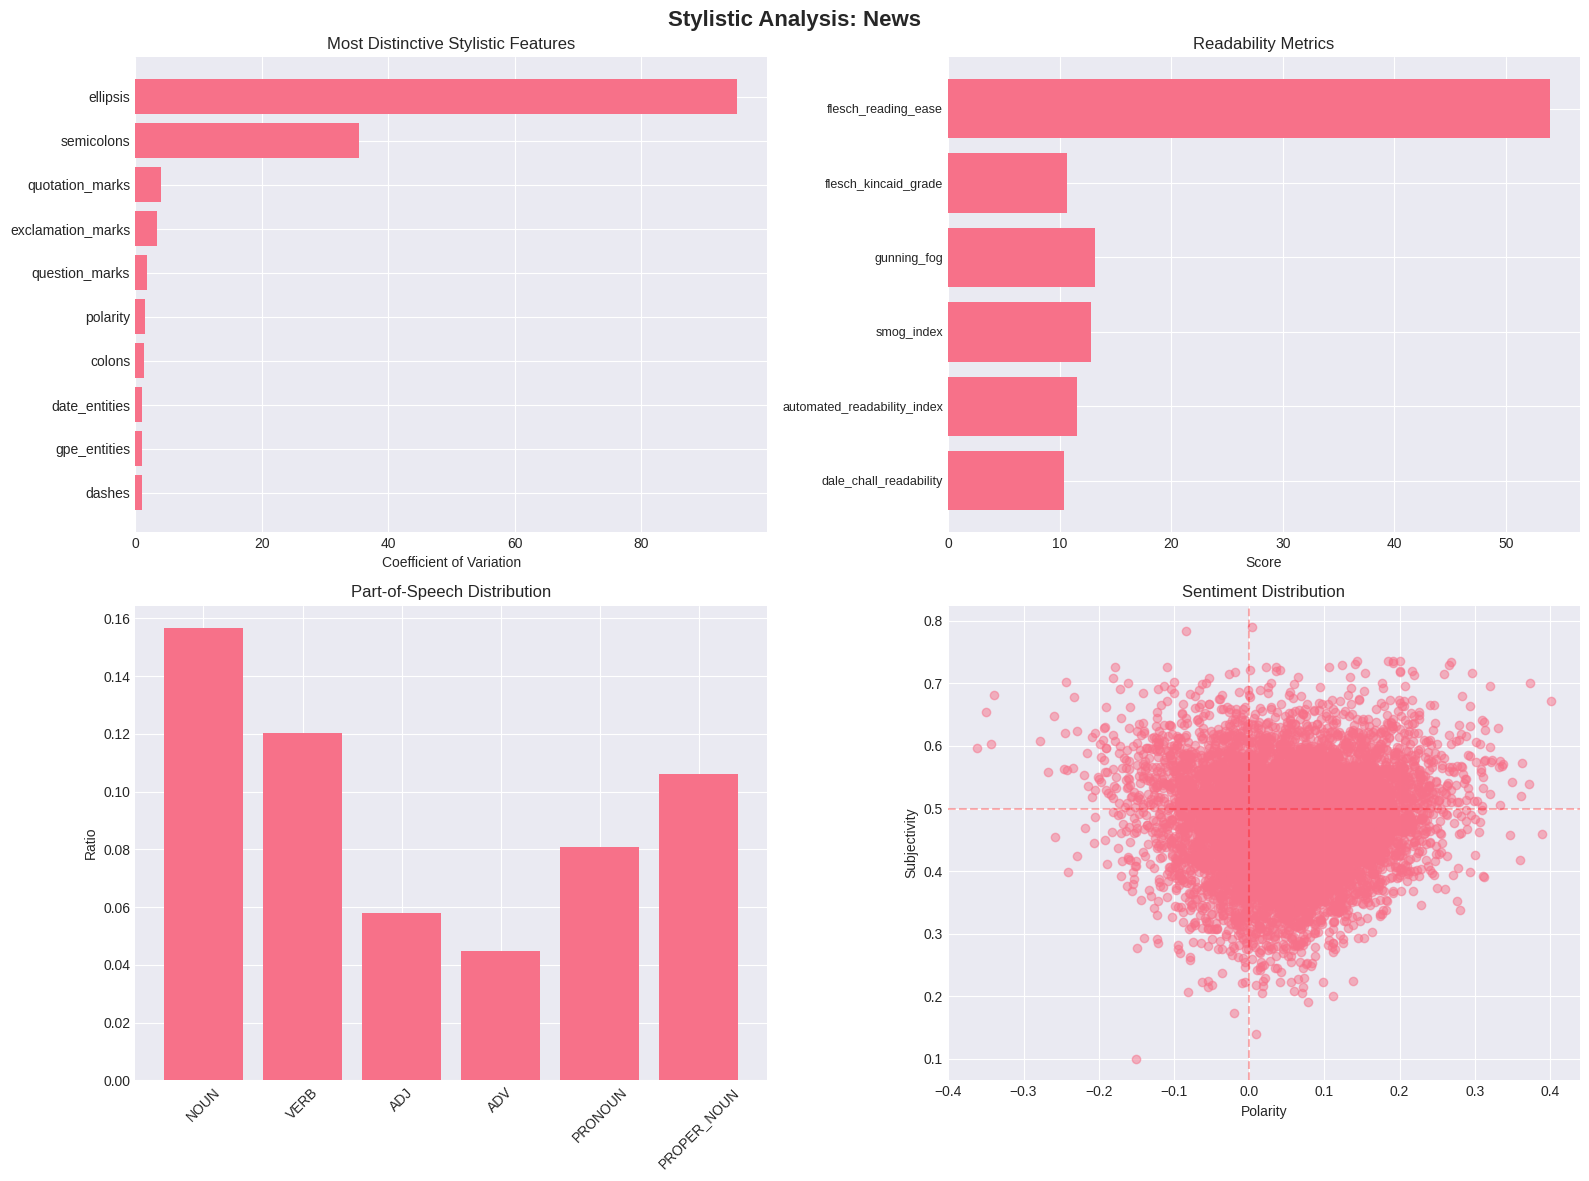


ANALYZING SUBJECT: POLITICS

Processing 6841 articles for subject: politics

Analyzing 6841 valid text documents

Performing topic modeling...

Extracting distinctive n-grams...

SUMMARY: POLITICS
Number of articles analyzed: 6841

--------------------------------------------------------------------------------
TOP 10 MOST DISTINCTIVE STYLISTIC FEATURES:
--------------------------------------------------------------------------------
 1. ellipsis                      : Mean=0.001, Std=0.035, CV=28.342
 2. semicolons                    : Mean=0.247, Std=1.616, CV=6.540
 3. quotation_marks               : Mean=0.340, Std=1.404, CV=4.125
 4. polarity                      : Mean=0.070, Std=0.153, CV=2.194
 5. exclamation_marks             : Mean=0.917, Std=1.818, CV=1.983
 6. colons                        : Mean=2.601, Std=4.837, CV=1.860
 7. question_marks                : Mean=1.132, Std=2.038, CV=1.800
 8. dashes                        : Mean=3.159, Std=5.520, CV=1.747
 9. coleman_liau

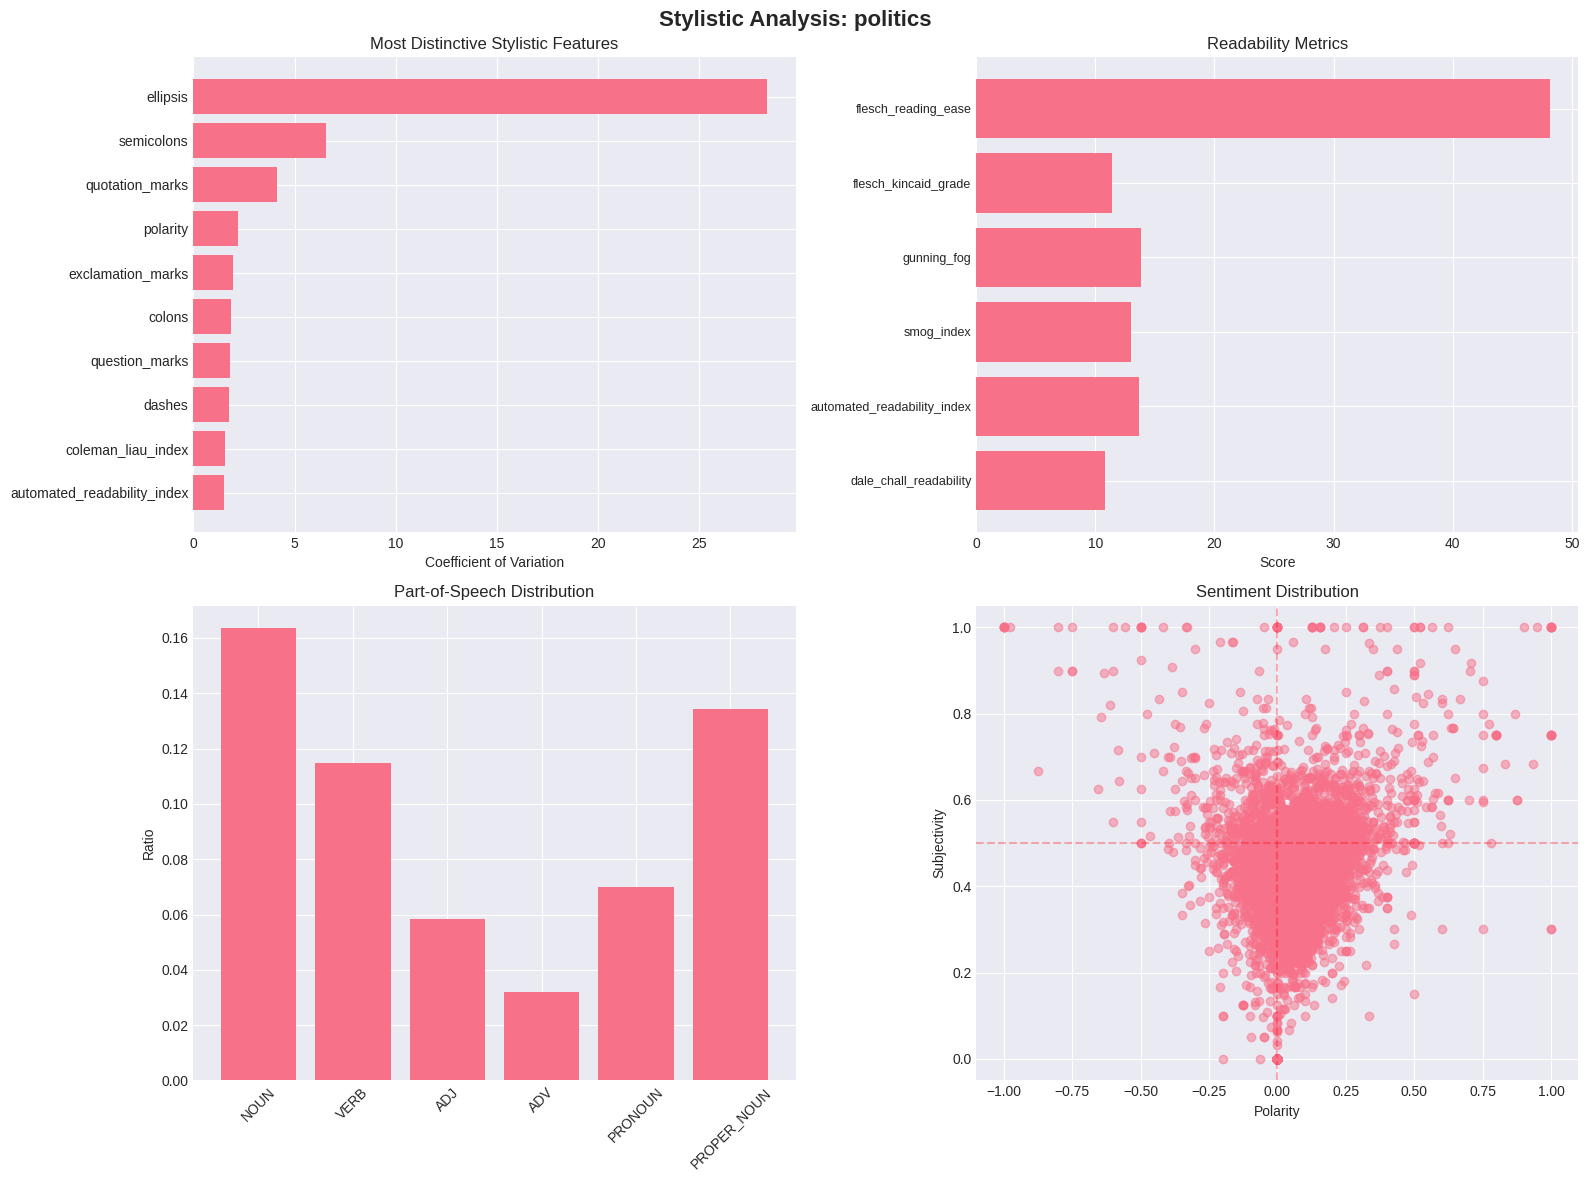


ANALYZING SUBJECT: GOVERNMENT NEWS

Processing 1570 articles for subject: Government News

Analyzing 1570 valid text documents

Performing topic modeling...

Extracting distinctive n-grams...

SUMMARY: GOVERNMENT NEWS
Number of articles analyzed: 1570

--------------------------------------------------------------------------------
TOP 10 MOST DISTINCTIVE STYLISTIC FEATURES:
--------------------------------------------------------------------------------
 1. ellipsis                      : Mean=0.003, Std=0.058, CV=17.286
 2. quotation_marks               : Mean=0.121, Std=0.922, CV=7.593
 3. semicolons                    : Mean=0.328, Std=1.569, CV=4.786
 4. polarity                      : Mean=0.062, Std=0.146, CV=2.357
 5. exclamation_marks             : Mean=0.798, Std=1.400, CV=1.755
 6. question_marks                : Mean=1.042, Std=1.800, CV=1.727
 7. colons                        : Mean=2.573, Std=4.083, CV=1.587
 8. gpe_entities                  : Mean=6.297, Std=9.054, CV=1

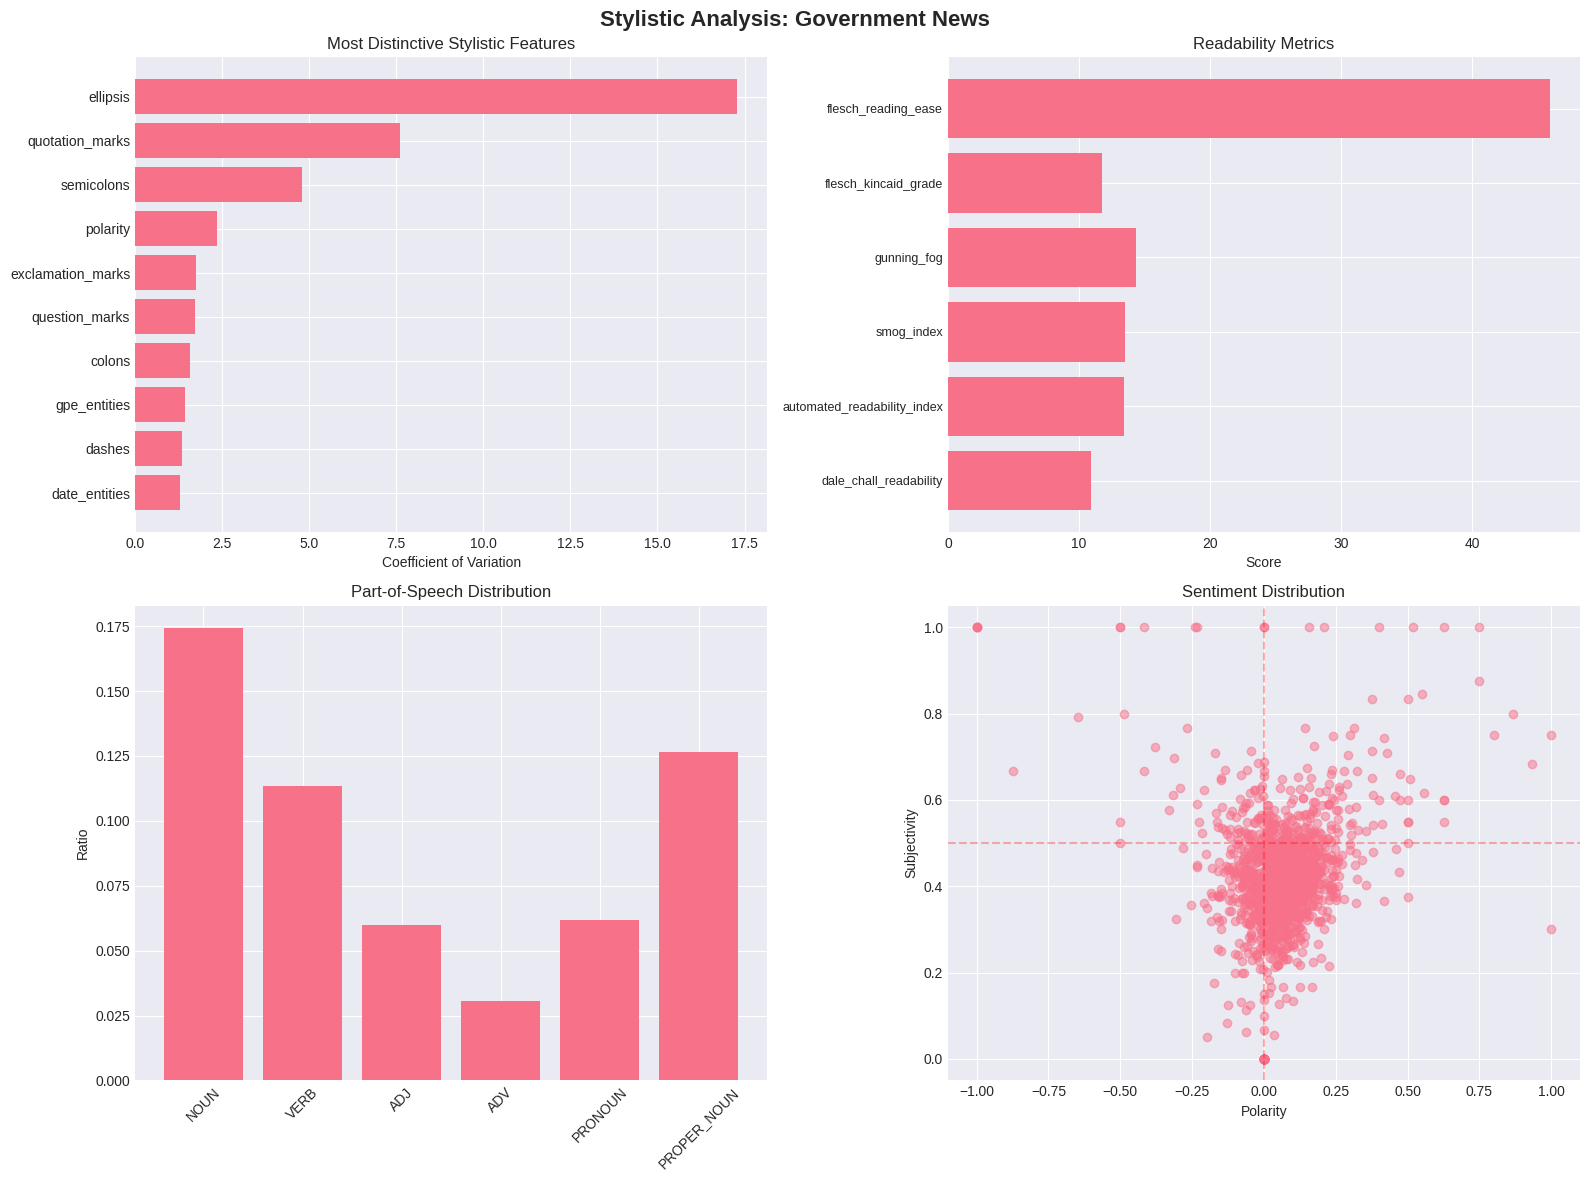


ANALYZING SUBJECT: LEFT-NEWS

Processing 4459 articles for subject: left-news

Analyzing 4459 valid text documents

Performing topic modeling...

Extracting distinctive n-grams...

SUMMARY: LEFT-NEWS
Number of articles analyzed: 4459

--------------------------------------------------------------------------------
TOP 10 MOST DISTINCTIVE STYLISTIC FEATURES:
--------------------------------------------------------------------------------
 1. ellipsis                      : Mean=0.001, Std=0.037, CV=26.783
 2. semicolons                    : Mean=0.320, Std=3.525, CV=11.014
 3. quotation_marks               : Mean=0.403, Std=1.450, CV=3.597
 4. exclamation_marks             : Mean=0.778, Std=1.836, CV=2.360
 5. polarity                      : Mean=0.056, Std=0.125, CV=2.244
 6. colons                        : Mean=2.787, Std=6.162, CV=2.211
 7. question_marks                : Mean=1.228, Std=2.125, CV=1.730
 8. dashes                        : Mean=3.659, Std=6.072, CV=1.659
 9. gpe_enti

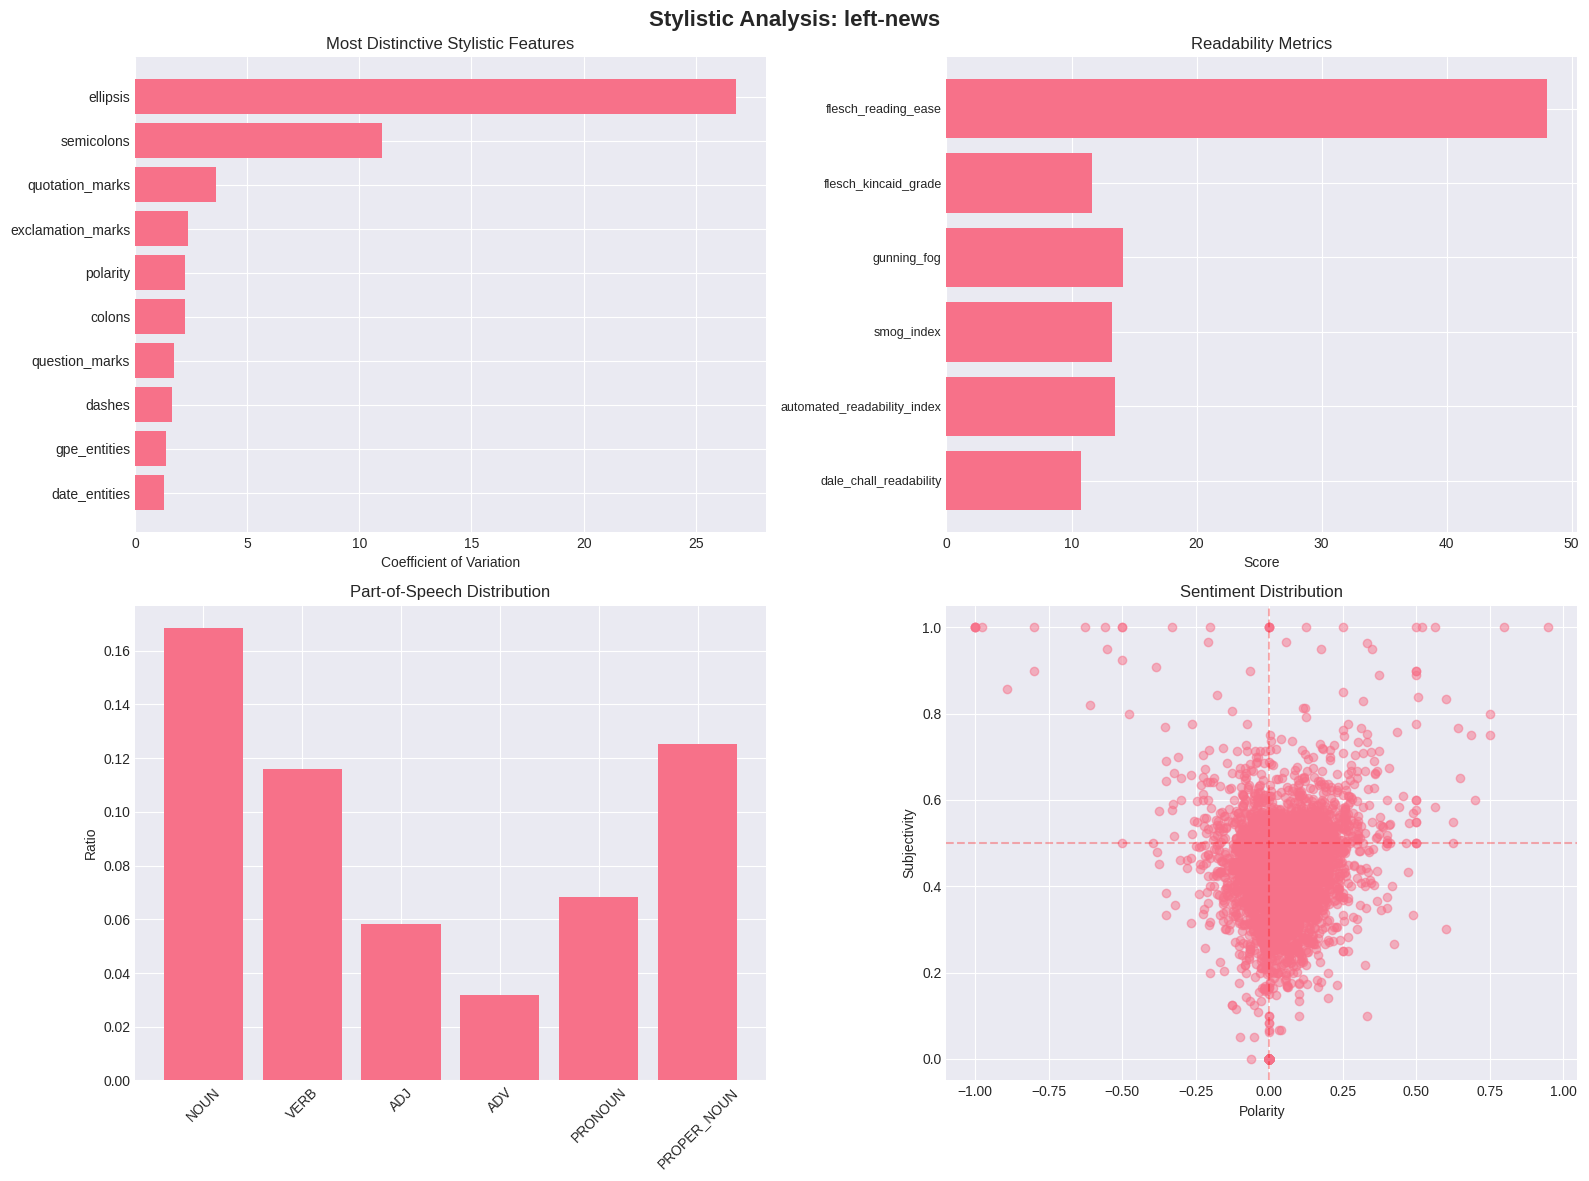


ANALYZING SUBJECT: US_NEWS

Processing 783 articles for subject: US_News

Analyzing 783 valid text documents

Performing topic modeling...

Extracting distinctive n-grams...

SUMMARY: US_NEWS
Number of articles analyzed: 783

--------------------------------------------------------------------------------
TOP 10 MOST DISTINCTIVE STYLISTIC FEATURES:
--------------------------------------------------------------------------------
 1. ellipsis                      : Mean=0.006, Std=0.080, CV=12.482
 2. quotation_marks               : Mean=0.130, Std=0.646, CV=4.962
 3. semicolons                    : Mean=0.503, Std=1.866, CV=3.709
 4. exclamation_marks             : Mean=0.480, Std=1.109, CV=2.309
 5. question_marks                : Mean=1.535, Std=2.767, CV=1.803
 6. gpe_entities                  : Mean=15.564, Std=24.609, CV=1.581
 7. dashes                        : Mean=8.902, Std=13.969, CV=1.569
 8. person_entities               : Mean=18.015, Std=27.783, CV=1.542
 9. org_entities 

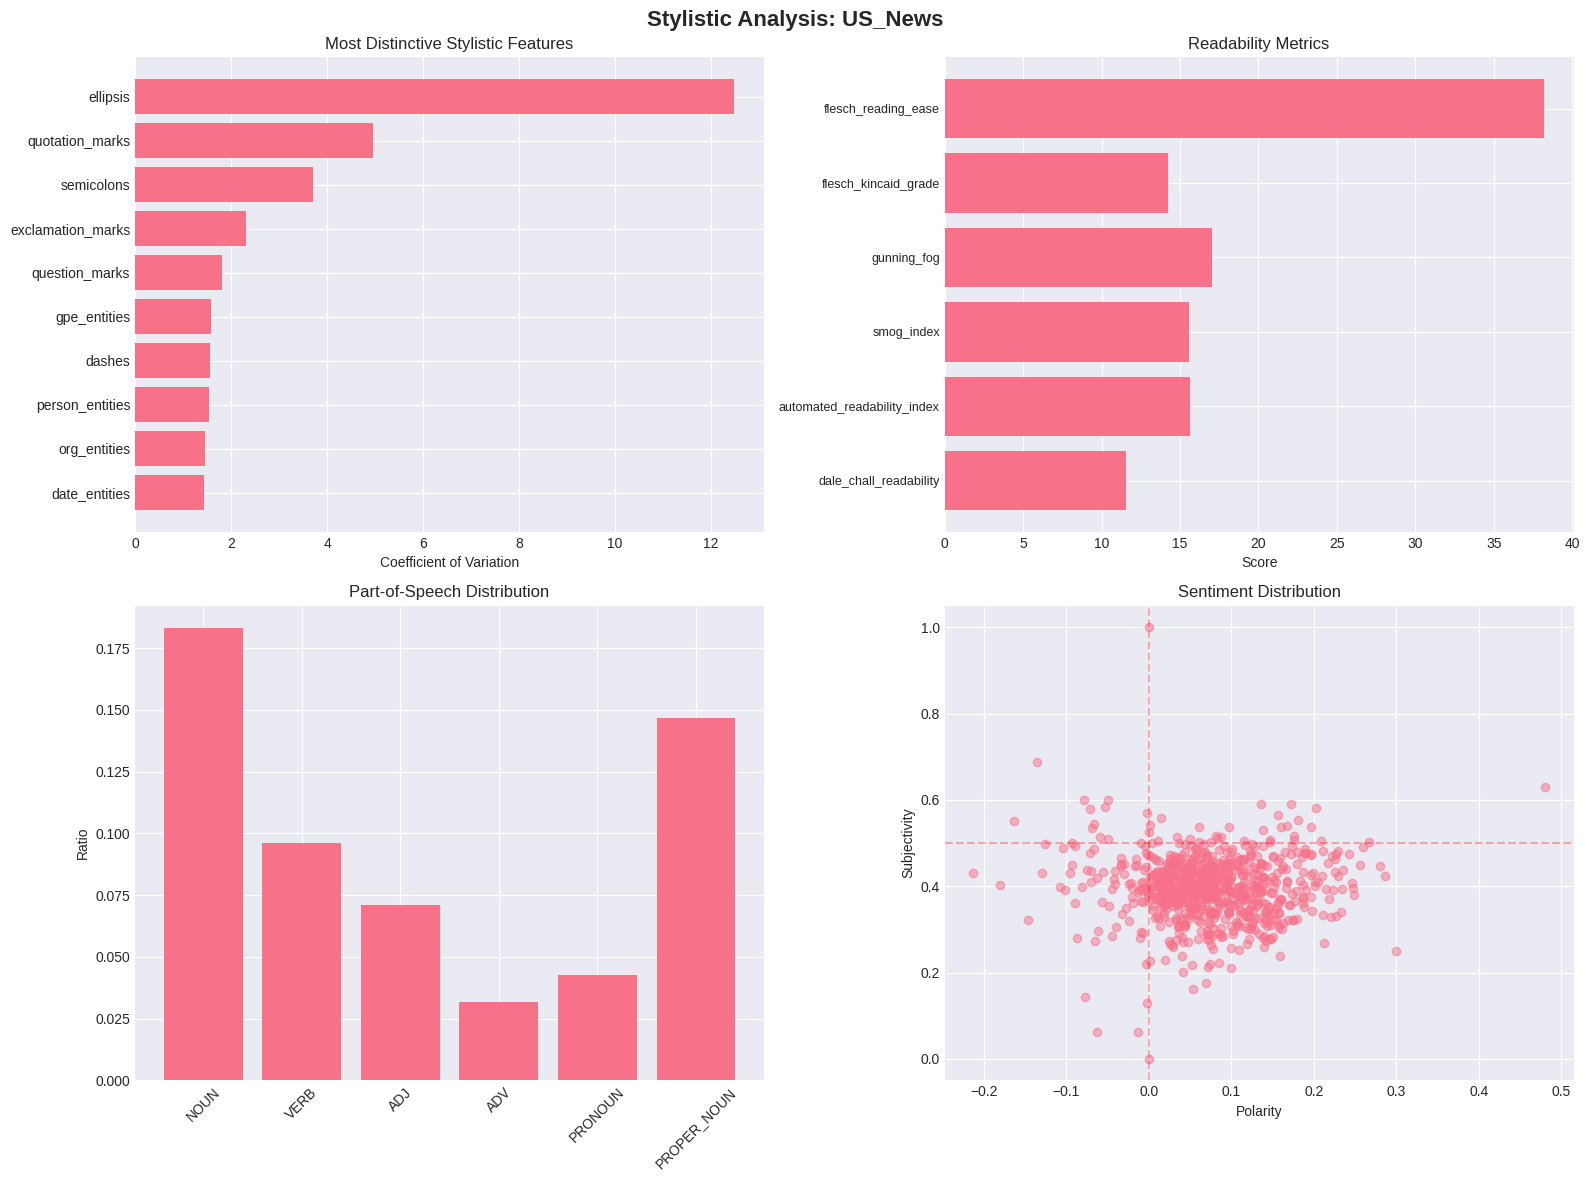


ANALYZING SUBJECT: MIDDLE-EAST

Processing 778 articles for subject: Middle-east

Analyzing 778 valid text documents

Performing topic modeling...

Extracting distinctive n-grams...

SUMMARY: MIDDLE-EAST
Number of articles analyzed: 778

--------------------------------------------------------------------------------
TOP 10 MOST DISTINCTIVE STYLISTIC FEATURES:
--------------------------------------------------------------------------------
 1. ellipsis                      : Mean=0.006, Std=0.080, CV=12.442
 2. quotation_marks               : Mean=0.131, Std=0.648, CV=4.945
 3. semicolons                    : Mean=0.496, Std=1.862, CV=3.752
 4. exclamation_marks             : Mean=0.479, Std=1.112, CV=2.319
 5. question_marks                : Mean=1.515, Std=2.695, CV=1.778
 6. gpe_entities                  : Mean=15.522, Std=24.662, CV=1.589
 7. dashes                        : Mean=8.832, Std=13.938, CV=1.578
 8. person_entities               : Mean=17.911, Std=27.773, CV=1.551
 9. o

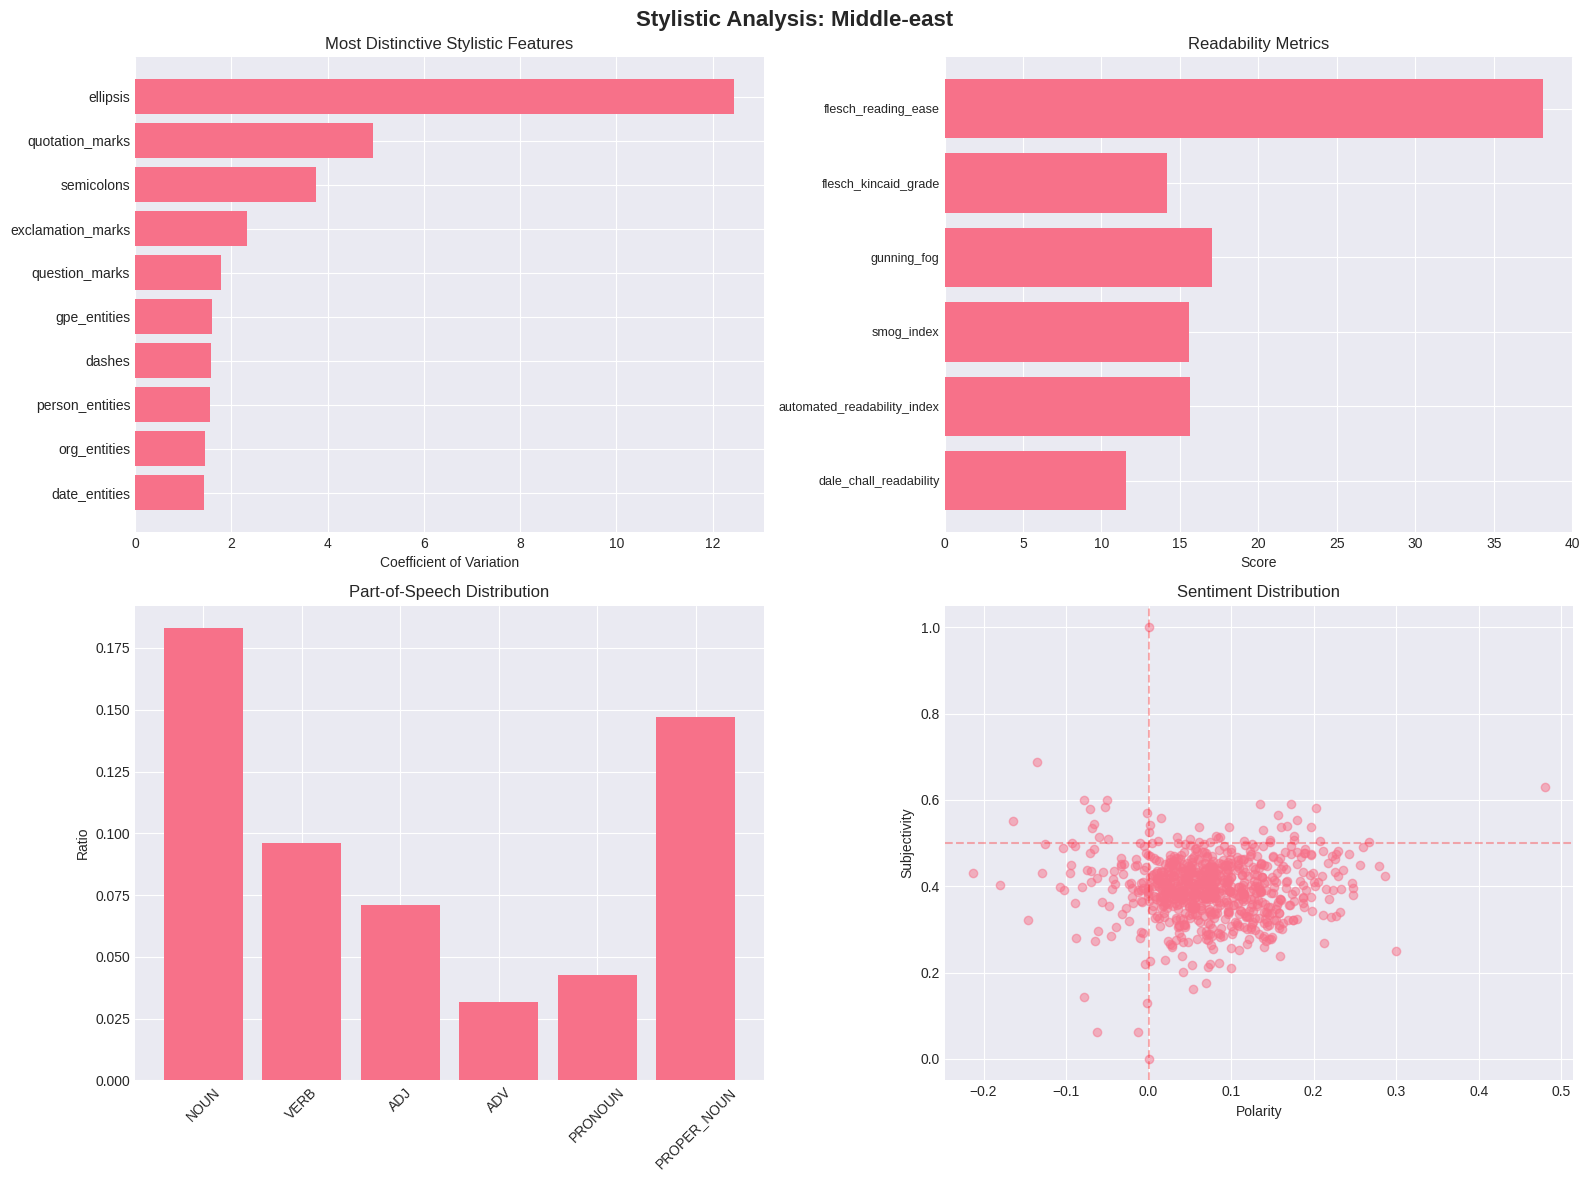


ANALYZING SUBJECT: POLITICSNEWS

Processing 11272 articles for subject: politicsNews

Analyzing 11272 valid text documents

Performing topic modeling...

Extracting distinctive n-grams...

SUMMARY: POLITICSNEWS
Number of articles analyzed: 11272

--------------------------------------------------------------------------------
TOP 10 MOST DISTINCTIVE STYLISTIC FEATURES:
--------------------------------------------------------------------------------
 1. quotation_marks               : Mean=0.039, Std=0.384, CV=9.828
 2. question_marks                : Mean=0.129, Std=0.796, CV=6.151
 3. exclamation_marks             : Mean=0.093, Std=0.539, CV=5.806
 4. semicolons                    : Mean=0.110, Std=0.558, CV=5.050
 5. colons                        : Mean=0.449, Std=2.087, CV=4.651
 6. ellipsis                      : Mean=0.149, Std=0.540, CV=3.636
 7. polarity                      : Mean=0.069, Std=0.094, CV=1.355
 8. gpe_entities                  : Mean=10.195, Std=10.422, CV=1.022


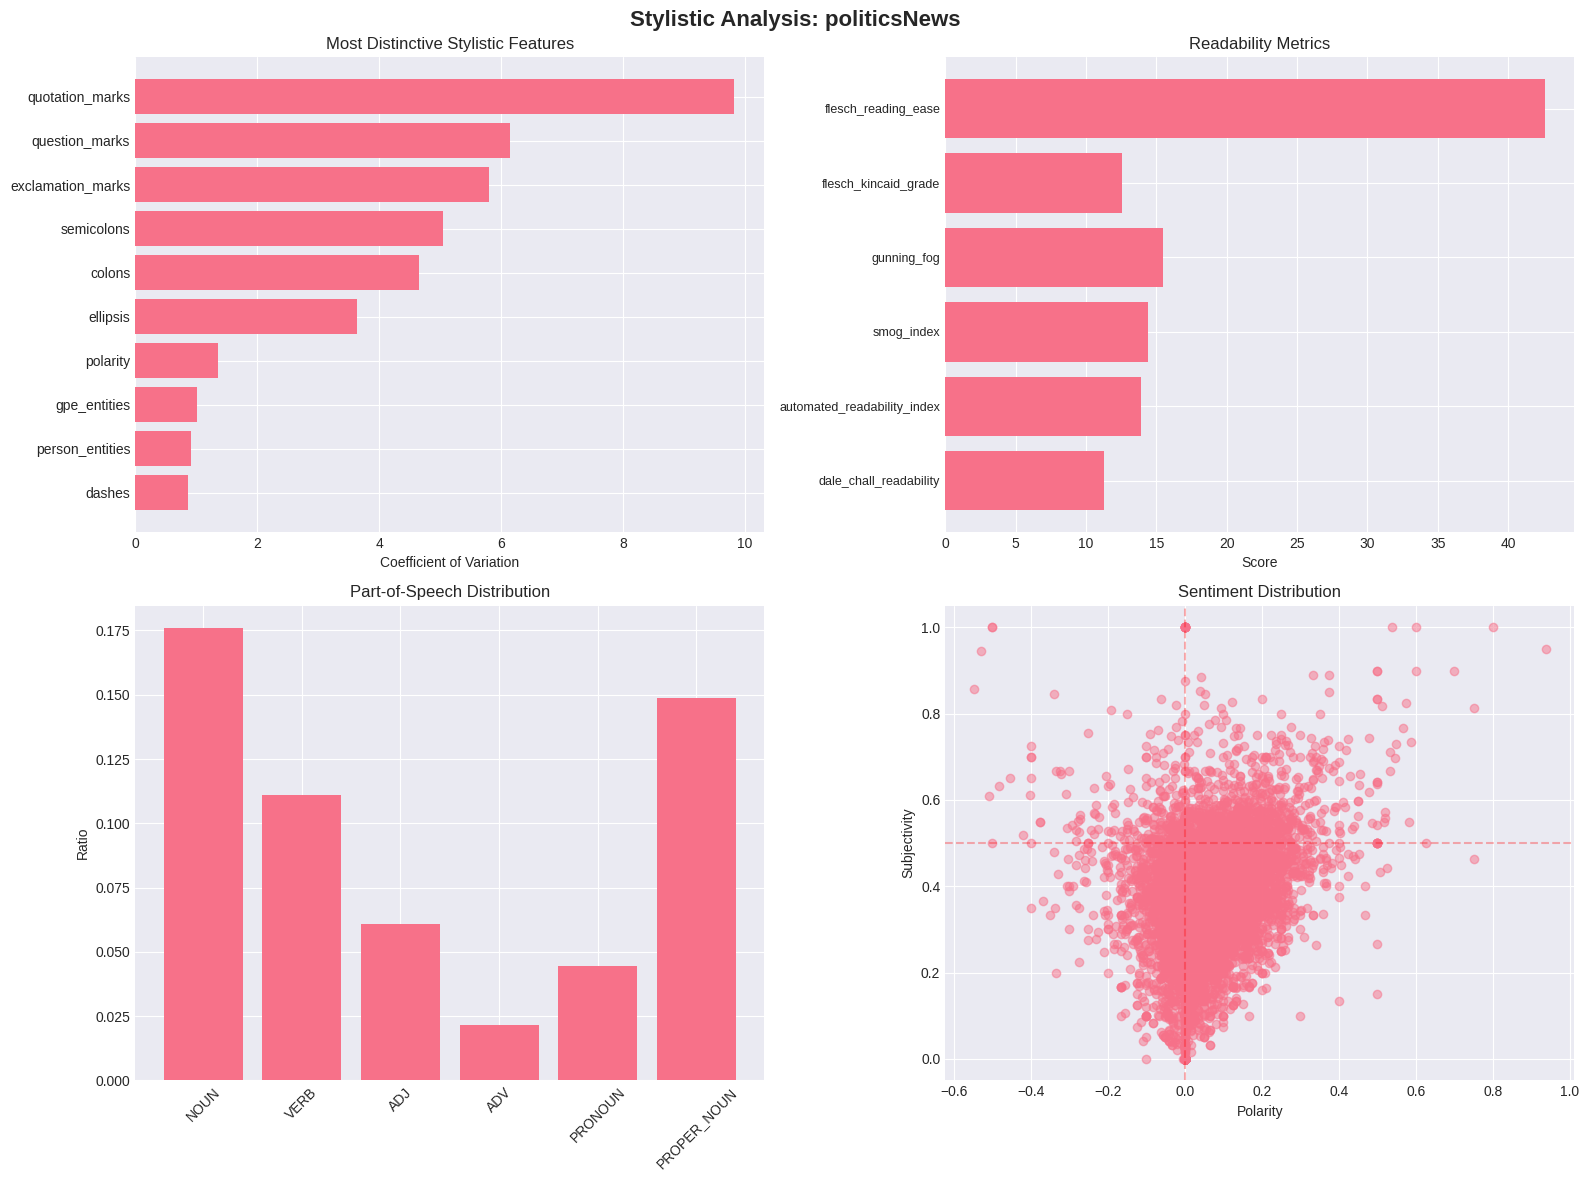


ANALYZING SUBJECT: WORLDNEWS

Processing 10145 articles for subject: worldnews

Analyzing 10145 valid text documents

Performing topic modeling...

Extracting distinctive n-grams...

SUMMARY: WORLDNEWS
Number of articles analyzed: 10145

--------------------------------------------------------------------------------
TOP 10 MOST DISTINCTIVE STYLISTIC FEATURES:
--------------------------------------------------------------------------------
 1. quotation_marks               : Mean=0.025, Std=0.303, CV=12.159
 2. exclamation_marks             : Mean=0.028, Std=0.207, CV=7.533
 3. semicolons                    : Mean=0.032, Std=0.225, CV=7.120
 4. question_marks                : Mean=0.069, Std=0.367, CV=5.328
 5. colons                        : Mean=0.234, Std=0.754, CV=3.225
 6. ellipsis                      : Mean=0.184, Std=0.517, CV=2.810
 7. polarity                      : Mean=0.036, Std=0.087, CV=2.391
 8. person_entities               : Mean=6.777, Std=6.589, CV=0.972
 9. gpe_en

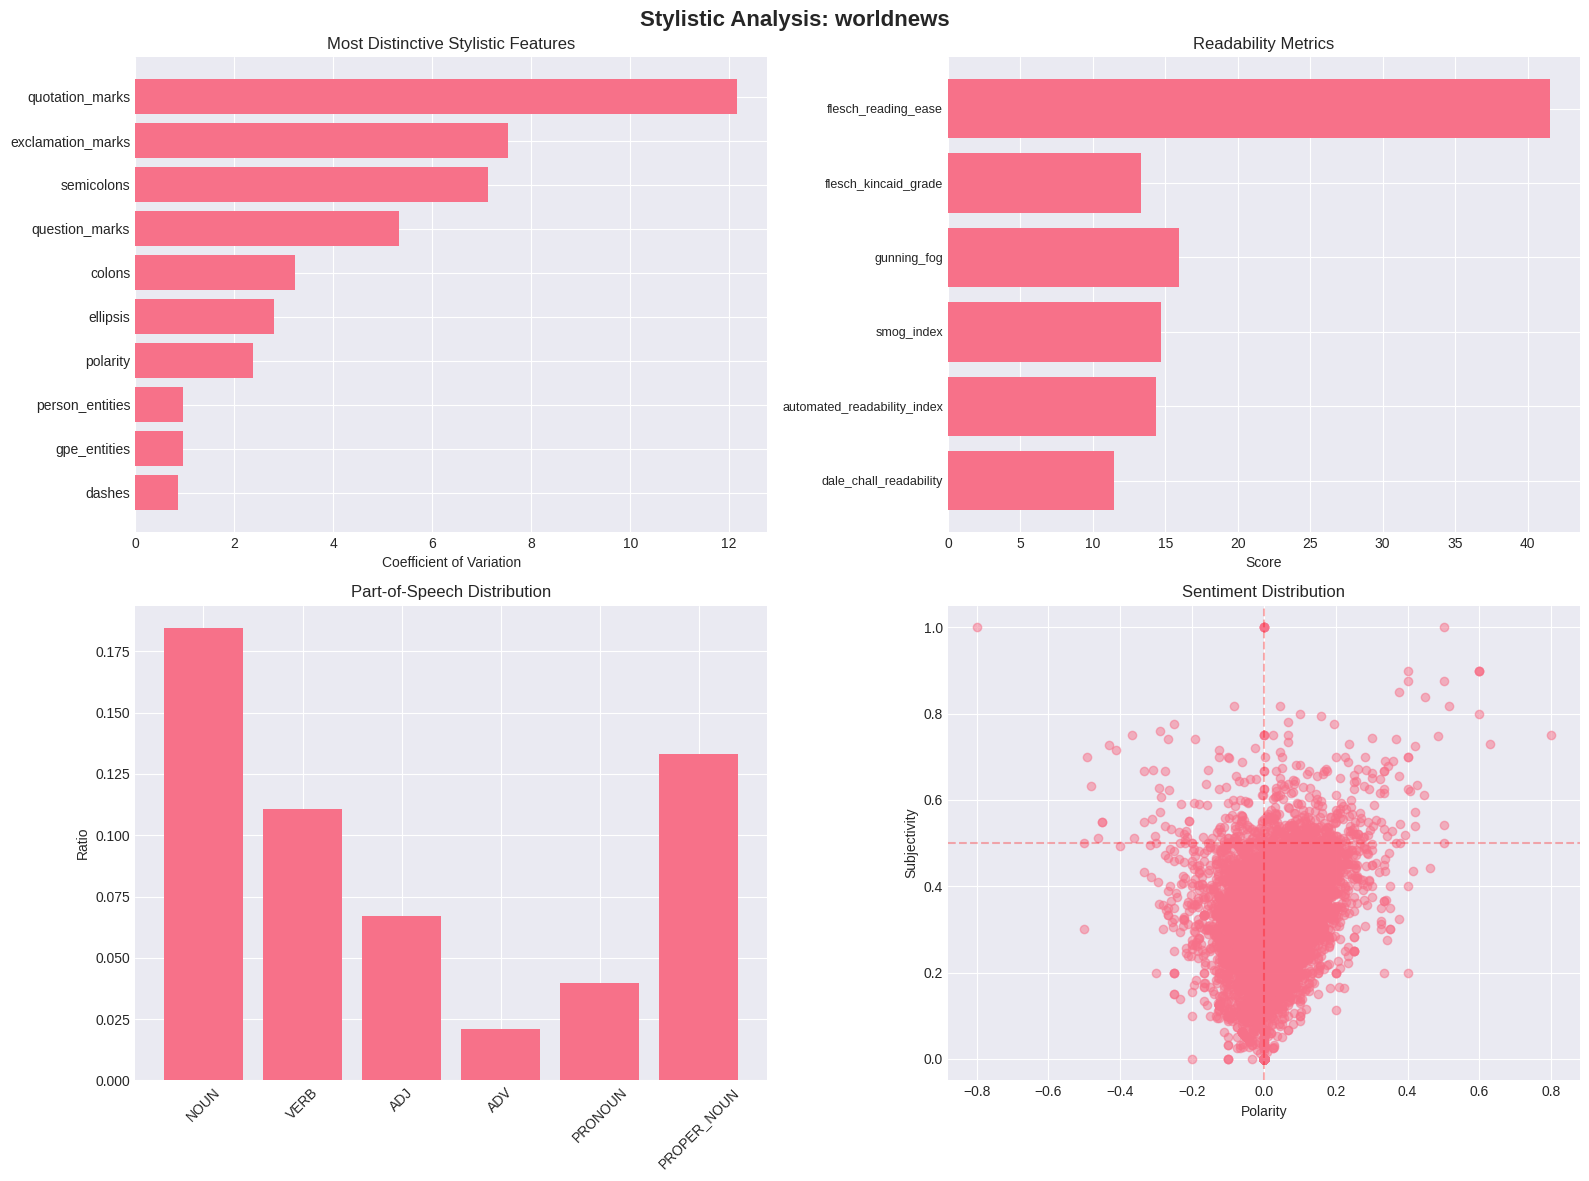

In [14]:
# Check if data is loaded
if df is None:
    print("ERROR: Please load your dataset first in the data loading section above.")
    print("The dataframe should have columns: 'subject' and 'text' (or 'content')")
else:
    # Get all unique subjects
    subjects = df['subject'].unique()
    print(f"Found {len(subjects)} unique subjects: {', '.join(subjects)}")
    
    # Analyze each subject
    all_results = {}
    
    for subject in subjects:
        try:
            results = analyze_subject(df, subject, n_topics=5, top_n_features=15)
            all_results[subject] = results
            
            # Print summary
            print_subject_summary(results)
            
            # Create visualization
            fig = visualize_subject_analysis(results)
            plt.show()
            
        except Exception as e:
            print(f"Error analyzing subject {subject}: {e}")
            import traceback
            traceback.print_exc()

## 8. Save Results

In [15]:
# Save results to files
output_dir = Path('../results/subject_analysis')
output_dir.mkdir(parents=True, exist_ok=True)

if 'all_results' in locals() and all_results:
    for subject, results in all_results.items():
        # Save stylistic features
        features_df = results['raw_features_df']
        features_df.to_csv(output_dir / f'{subject}_stylistic_features.csv', index=False)
        
        # Save topics
        topics_data = [
            {
                'topic_id': t['topic_id'],
                'top_words': ', '.join(t['top_words'])
            }
            for t in results['topics']
        ]
        pd.DataFrame(topics_data).to_csv(output_dir / f'{subject}_topics.csv', index=False)
        
        # Save n-grams
        for ngram_type, ngrams in results['ngrams'].items():
            ngram_df = pd.DataFrame(ngrams)
            ngram_df.to_csv(output_dir / f'{subject}_{ngram_type}.csv', index=False)
        
        # Save summary statistics
        summary_df = pd.DataFrame(results['stylistic_features']['most_distinctive'])
        summary_df.to_csv(output_dir / f'{subject}_distinctive_features_summary.csv')
    
    print(f"\nResults saved to {output_dir}")
else:
    print("No results to save. Please run the analysis first.")


Results saved to ../results/subject_analysis


## 9. Cross-Subject Comparison (Optional)

While the main focus is on individual subject analysis, this section provides a quick comparison view.


Cross-Subject Comparison:
        subject  n_articles  mean_word_count  mean_avg_sentence_length  mean_lexical_diversity  mean_flesch_reading_ease  mean_polarity  mean_subjectivity
           News        9050       441.253812                 19.207016                0.578945                 53.920015       0.055413           0.475904
       politics        6841       368.744132                 18.588074                0.647215                 48.148697       0.069554           0.432657
Government News        1570       406.024700                 18.987320                0.629613                 45.935583       0.062087           0.416482
      left-news        4459       406.407751                 19.469904                0.625063                 48.031409       0.055637           0.429420
        US_News         783       780.527458                 24.609120                0.617026                 38.180584       0.073524           0.396305
    Middle-east         778       772.54884

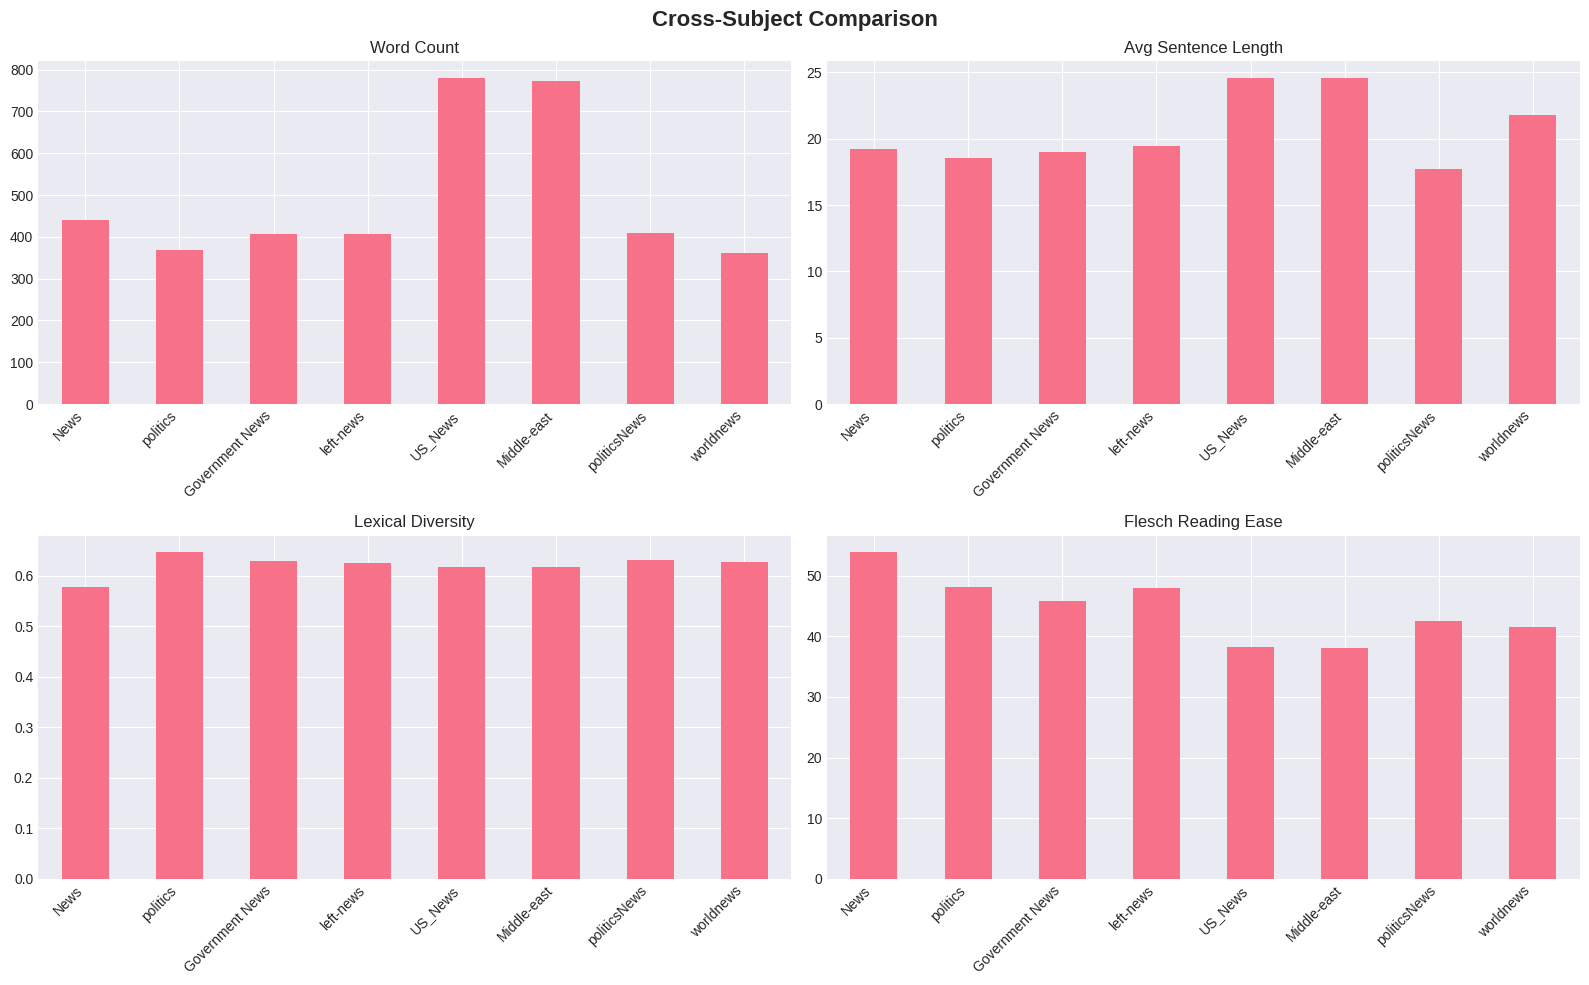


Comparison saved to ../results/subject_analysis/cross_subject_comparison.csv


In [16]:
if 'all_results' in locals() and len(all_results) > 1:
    # Compare key metrics across subjects
    comparison_data = []
    
    for subject, results in all_results.items():
        features_df = results['raw_features_df']
        
        row = {
            'subject': subject,
            'n_articles': results['n_articles'],
        }
        
        # Add mean values for key features
        for col in ['word_count', 'avg_sentence_length', 'lexical_diversity', 
                   'flesch_reading_ease', 'polarity', 'subjectivity']:
            if col in features_df.columns:
                row[f'mean_{col}'] = features_df[col].mean()
        
        comparison_data.append(row)
    
    comparison_df = pd.DataFrame(comparison_data)
    
    print("\nCross-Subject Comparison:")
    print(comparison_df.to_string(index=False))
    
    # Visualize comparison
    numeric_cols = [col for col in comparison_df.columns if col not in ['subject', 'n_articles']]
    if numeric_cols:
        fig, axes = plt.subplots(2, 2, figsize=(16, 10))
        fig.suptitle('Cross-Subject Comparison', fontsize=16, fontweight='bold')
        
        for idx, col in enumerate(numeric_cols[:4]):
            ax = axes[idx // 2, idx % 2]
            comparison_df.plot(x='subject', y=col, kind='bar', ax=ax, legend=False)
            ax.set_title(col.replace('mean_', '').replace('_', ' ').title())
            ax.set_xlabel('')
            plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
        
        plt.tight_layout()
        plt.show()
        
        # Save comparison
        comparison_df.to_csv(output_dir / 'cross_subject_comparison.csv', index=False)
        print(f"\nComparison saved to {output_dir / 'cross_subject_comparison.csv'}")

## 10. Export Summary Report

In [17]:
# Create a comprehensive markdown report
if 'all_results' in locals() and all_results:
    report_path = output_dir / 'subject_analysis_report.md'
    
    with open(report_path, 'w') as f:
        f.write("# Subject-Specific Feature Analysis Report\n\n")
        f.write(f"Generated: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
        f.write("---\n\n")
        
        for subject, results in all_results.items():
            f.write(f"## Subject: {subject}\n\n")
            f.write(f"**Articles Analyzed:** {results['n_articles']}\n\n")
            
            f.write("### Top 10 Distinctive Stylistic Features\n\n")
            distinctive = pd.DataFrame(results['stylistic_features']['most_distinctive'])
            if 'mean' in distinctive.columns:
                f.write("| Feature | Mean | Std | CV |\n")
                f.write("|---------|------|-----|-------|\n")
                for feature, row in distinctive.head(10).iterrows():
                    f.write(f"| {feature} | {row['mean']:.3f} | {row['std']:.3f} | {row['coefficient_of_variation']:.3f} |\n")
            
            f.write("\n### Discovered Topics\n\n")
            for topic in results['topics']:
                f.write(f"- **Topic {topic['topic_id'] + 1}:** {', '.join(topic['top_words'][:10])}\n")
            
            f.write("\n### Top N-grams\n\n")
            for ngram_type, ngrams in results['ngrams'].items():
                f.write(f"#### {ngram_type}\n\n")
                for i, ngram_info in enumerate(ngrams[:10], 1):
                    f.write(f"{i}. {ngram_info['ngram']} (TF-IDF: {ngram_info['tfidf_score']:.4f})\n")
                f.write("\n")
            
            f.write("\n---\n\n")
    
    print(f"\nComprehensive report saved to {report_path}")


Comprehensive report saved to ../results/subject_analysis/subject_analysis_report.md


## 11. Advanced Cross-Subject Feature Analysis

This section identifies which features are most distinctive for each subject by comparing across all subjects.

In [18]:
if 'all_results' in locals() and len(all_results) > 1:
    # Compile all features from all subjects into one dataframe
    all_features_data = []
    
    for subject, results in all_results.items():
        features_df = results['raw_features_df']
        features_df['subject'] = subject
        all_features_data.append(features_df)
    
    # Combine all features
    combined_features = pd.concat(all_features_data, ignore_index=True)
    
    print(f"Combined features dataset shape: {combined_features.shape}")
    print(f"Subjects: {combined_features['subject'].unique()}")
    
    # Get numeric columns only (exclude subject)
    numeric_cols = combined_features.select_dtypes(include=[np.number]).columns.tolist()
    print(f"\nTotal numeric features: {len(numeric_cols)}")
else:
    print("Please run the subject analysis first (cell 20)")

Combined features dataset shape: (44898, 36)
Subjects: ['News' 'politics' 'Government News' 'left-news' 'US_News' 'Middle-east'
 'politicsNews' 'worldnews']

Total numeric features: 35


In [19]:
# Calculate mean and std for each feature per subject
subject_feature_stats = combined_features.groupby('subject')[numeric_cols].agg(['mean', 'std'])

# Flatten column names
subject_feature_stats.columns = ['_'.join(col).strip() for col in subject_feature_stats.columns.values]

# Calculate Z-scores: how many standard deviations each subject is from the overall mean
feature_means_by_subject = combined_features.groupby('subject')[numeric_cols].mean()
overall_means = combined_features[numeric_cols].mean()
overall_stds = combined_features[numeric_cols].std()

# Calculate z-scores for each subject relative to all subjects
z_scores = pd.DataFrame()
for subject in feature_means_by_subject.index:
    subject_z = (feature_means_by_subject.loc[subject] - overall_means) / overall_stds
    z_scores[subject] = subject_z

z_scores = z_scores.T

print("Z-scores calculated (how many standard deviations each subject differs from the mean)")
print(f"Z-scores shape: {z_scores.shape}")
print("\nSample of z-scores:")
print(z_scores.iloc[:3, :5])

Z-scores calculated (how many standard deviations each subject differs from the mean)
Z-scores shape: (8, 35)

Sample of z-scores:
                 char_count  word_count  sentence_count  avg_word_length  \
Government News   -0.017856   -0.014369       -0.003787         0.063014   
Middle-east        1.059416    1.031684        0.551188         0.010295   
News               0.054768    0.086174        0.123270        -0.118978   

                 avg_sentence_length  
Government News            -0.089593  
Middle-east                 0.802095  
News                       -0.054739  


In [20]:
# Filter out rare features (low variance across all subjects)
# Keep features where overall std is meaningful (> 0.01)
meaningful_features = []
for col in numeric_cols:
    if overall_stds[col] > 0.01 and overall_means[col] > 0.01:
        meaningful_features.append(col)

print(f"\nFiltered from {len(numeric_cols)} to {len(meaningful_features)} meaningful features")
print(f"(Excluded features with very low variance or near-zero means)")

# Create filtered z-scores
z_scores_filtered = z_scores[meaningful_features]

print(f"\nFiltered z-scores shape: {z_scores_filtered.shape}")


Filtered from 35 to 35 meaningful features
(Excluded features with very low variance or near-zero means)

Filtered z-scores shape: (8, 35)


### 11.1 Top Distinctive Features Per Subject

For each subject, identify features where that subject stands out the most (highest absolute z-score)

In [21]:
# For each subject, find top features by absolute z-score
top_n_per_subject = 10

subject_distinctive_features = {}

print("="*100)
print("TOP DISTINCTIVE FEATURES PER SUBJECT (by Z-Score)")
print("="*100)

for subject in z_scores_filtered.index:
    subject_z = z_scores_filtered.loc[subject]
    
    # Sort by absolute value to find most distinctive (either high or low)
    top_features = subject_z.abs().nlargest(top_n_per_subject)
    
    print(f"\n{subject.upper()}")
    print("-"*100)
    print(f"{'Rank':<6} {'Feature':<40} {'Z-Score':<12} {'Direction':<12}")
    print("-"*100)
    
    distinctive_list = []
    for rank, (feature, abs_z) in enumerate(top_features.items(), 1):
        actual_z = subject_z[feature]
        direction = "Higher ↑" if actual_z > 0 else "Lower ↓"
        print(f"{rank:<6} {feature:<40} {actual_z:>10.3f}   {direction:<12}")
        
        distinctive_list.append({
            'rank': rank,
            'feature': feature,
            'z_score': actual_z,
            'abs_z_score': abs_z,
            'direction': direction,
            'mean_value': feature_means_by_subject.loc[subject, feature],
            'overall_mean': overall_means[feature]
        })
    
    subject_distinctive_features[subject] = pd.DataFrame(distinctive_list)

print("\n" + "="*100)

TOP DISTINCTIVE FEATURES PER SUBJECT (by Z-Score)

GOVERNMENT NEWS
----------------------------------------------------------------------------------------------------
Rank   Feature                                  Z-Score      Direction   
----------------------------------------------------------------------------------------------------
1      entity_density                               -0.280   Lower ↓     
2      exclamation_marks                             0.262   Higher ↑    
3      colons                                        0.262   Higher ↑    
4      avg_dependency_distance                      -0.215   Lower ↓     
5      ellipsis                                     -0.204   Lower ↓     
6      date_entities                                -0.202   Lower ↓     
7      question_marks                                0.196   Higher ↑    
8      dashes                                       -0.189   Lower ↓     
9      smog_index                                   -0.169   Lowe

### 11.2 Feature Ranking: Which Subject is Most/Least Prone to Each Feature

In [22]:
# Create tables showing which subjects rank highest/lowest for key feature categories
feature_categories = {
    'Readability': ['flesch_reading_ease', 'flesch_kincaid_grade', 'gunning_fog', 'smog_index'],
    'Text Length': ['word_count', 'char_count', 'sentence_count', 'avg_sentence_length', 'avg_word_length'],
    'Lexical': ['lexical_diversity'],
    'Sentiment': ['polarity', 'subjectivity'],
    'Punctuation': ['exclamation_marks', 'question_marks', 'commas', 'quotation_marks'],
    'POS Ratios': ['noun_ratio', 'verb_ratio', 'adj_ratio', 'adv_ratio', 'pronoun_ratio', 'proper_noun_ratio'],
    'Entities': ['entity_density', 'person_entities', 'org_entities', 'gpe_entities']
}

# Create ranking tables
feature_rankings = {}

for category, features in feature_categories.items():
    # Filter to features that exist
    available_features = [f for f in features if f in feature_means_by_subject.columns]
    
    if not available_features:
        continue
    
    print(f"\n{'='*100}")
    print(f"CATEGORY: {category.upper()}")
    print(f"{'='*100}")
    
    category_data = []
    
    for feature in available_features:
        # Rank subjects by this feature
        ranked = feature_means_by_subject[feature].sort_values(ascending=False)
        
        print(f"\n{feature}:")
        print(f"  Highest: {ranked.index[0]:<20} ({ranked.iloc[0]:.3f})")
        print(f"  Lowest:  {ranked.index[-1]:<20} ({ranked.iloc[-1]:.3f})")
        print(f"  Range:   {ranked.iloc[0] - ranked.iloc[-1]:.3f}")
        
        category_data.append({
            'feature': feature,
            'highest_subject': ranked.index[0],
            'highest_value': ranked.iloc[0],
            'lowest_subject': ranked.index[-1],
            'lowest_value': ranked.iloc[-1],
            'range': ranked.iloc[0] - ranked.iloc[-1],
            'overall_mean': overall_means[feature]
        })
    
    feature_rankings[category] = pd.DataFrame(category_data)


CATEGORY: READABILITY

flesch_reading_ease:
  Highest: News                 (53.920)
  Lowest:  Middle-east          (38.162)
  Range:   15.758

flesch_kincaid_grade:
  Highest: Middle-east          (14.210)
  Lowest:  News                 (10.642)
  Range:   3.568

gunning_fog:
  Highest: Middle-east          (17.023)
  Lowest:  News                 (13.157)
  Range:   3.866

smog_index:
  Highest: Middle-east          (15.551)
  Lowest:  News                 (12.787)
  Range:   2.763

CATEGORY: TEXT LENGTH

word_count:
  Highest: US_News              (780.527)
  Lowest:  worldnews            (360.690)
  Range:   419.838

char_count:
  Highest: US_News              (4847.337)
  Lowest:  worldnews            (2198.603)
  Range:   2648.734

sentence_count:
  Highest: US_News              (33.308)
  Lowest:  worldnews            (18.092)
  Range:   15.216

avg_sentence_length:
  Highest: US_News              (24.609)
  Lowest:  politicsNews         (17.735)
  Range:   6.874

avg_word_le

### 11.3 Heatmap Visualization of Subject-Feature Relationships

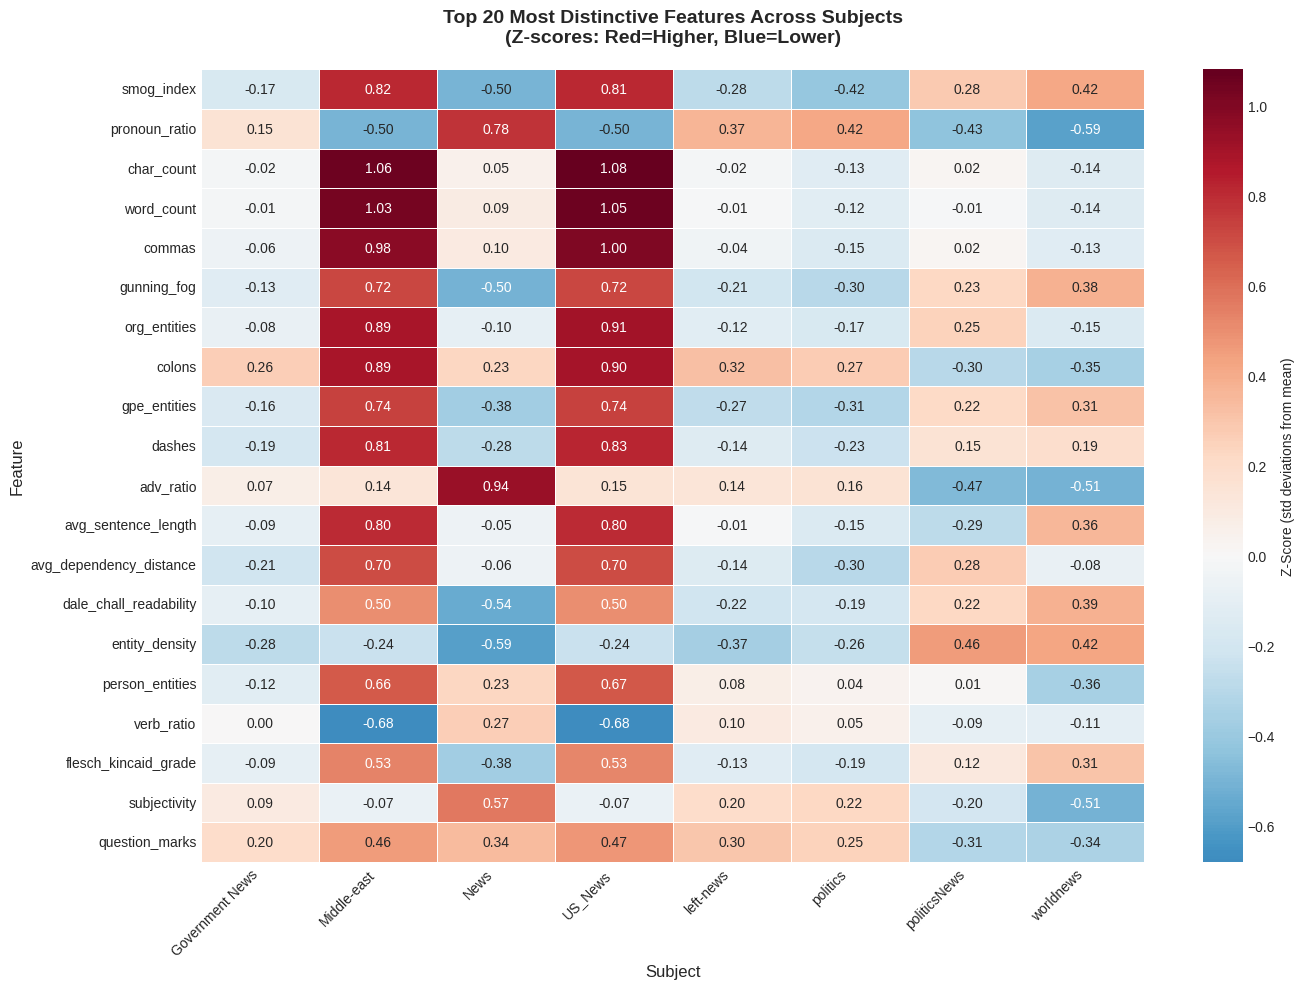


Heatmap saved to ../results/subject_analysis/feature_heatmap_zscores.png


In [23]:
# Select most distinctive features overall (highest variance across subjects)
feature_variance = z_scores_filtered.var(axis=0).sort_values(ascending=False)
top_distinctive_overall = feature_variance.head(20).index.tolist()

# Create heatmap of z-scores for these features
plt.figure(figsize=(14, 10))
sns.heatmap(
    z_scores_filtered[top_distinctive_overall].T,
    cmap='RdBu_r',
    center=0,
    annot=True,
    fmt='.2f',
    cbar_kws={'label': 'Z-Score (std deviations from mean)'},
    linewidths=0.5
)
plt.title('Top 20 Most Distinctive Features Across Subjects\n(Z-scores: Red=Higher, Blue=Lower)', 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Subject', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(output_dir / 'feature_heatmap_zscores.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nHeatmap saved to {output_dir / 'feature_heatmap_zscores.png'}")

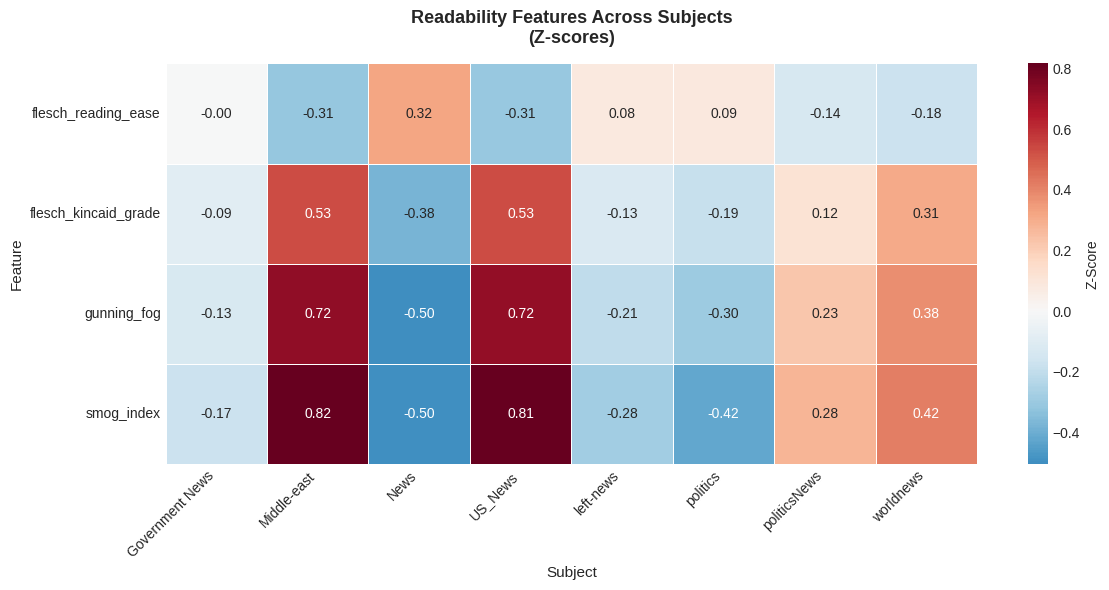

Saved: heatmap_readability.png


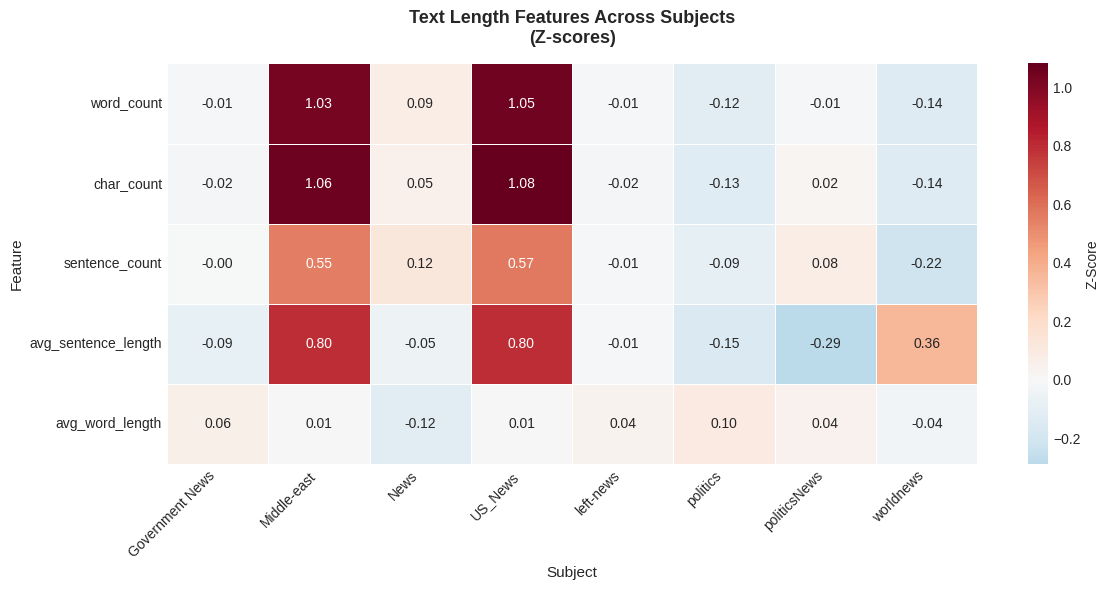

Saved: heatmap_text_length.png


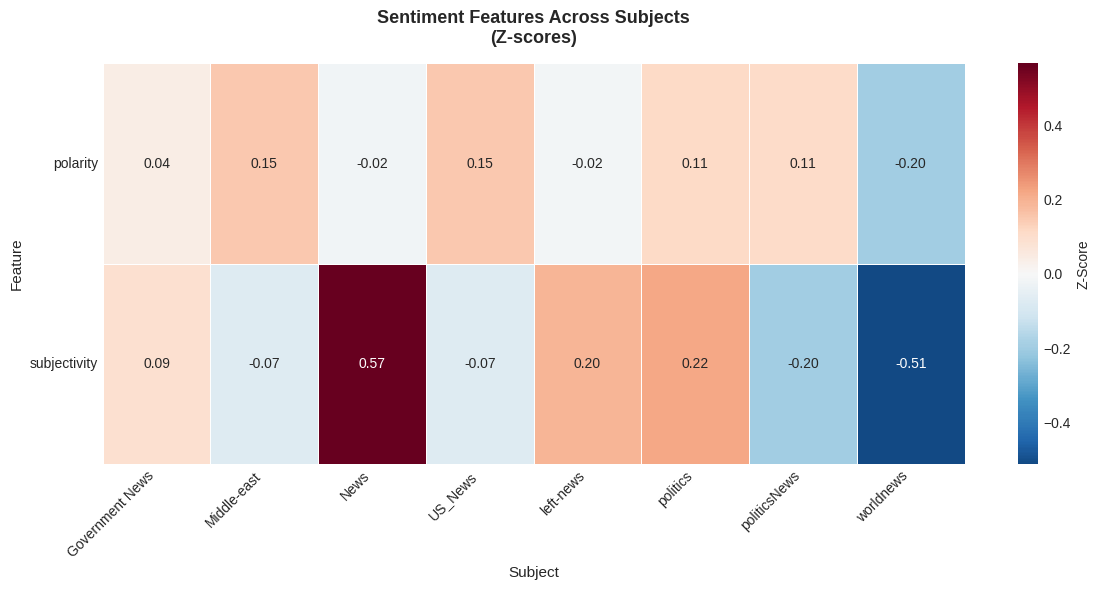

Saved: heatmap_sentiment.png


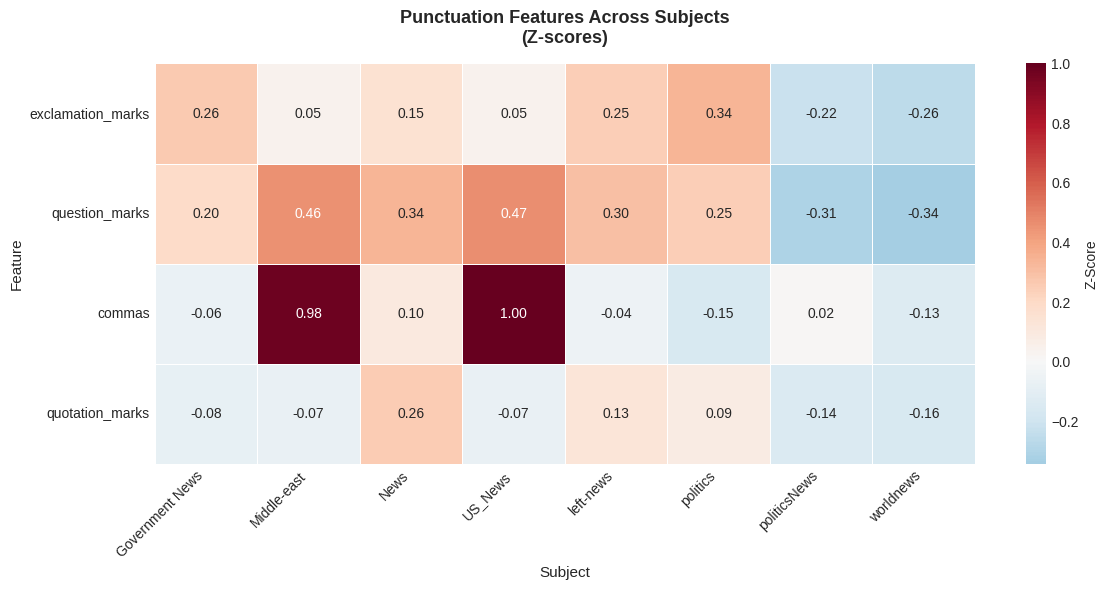

Saved: heatmap_punctuation.png


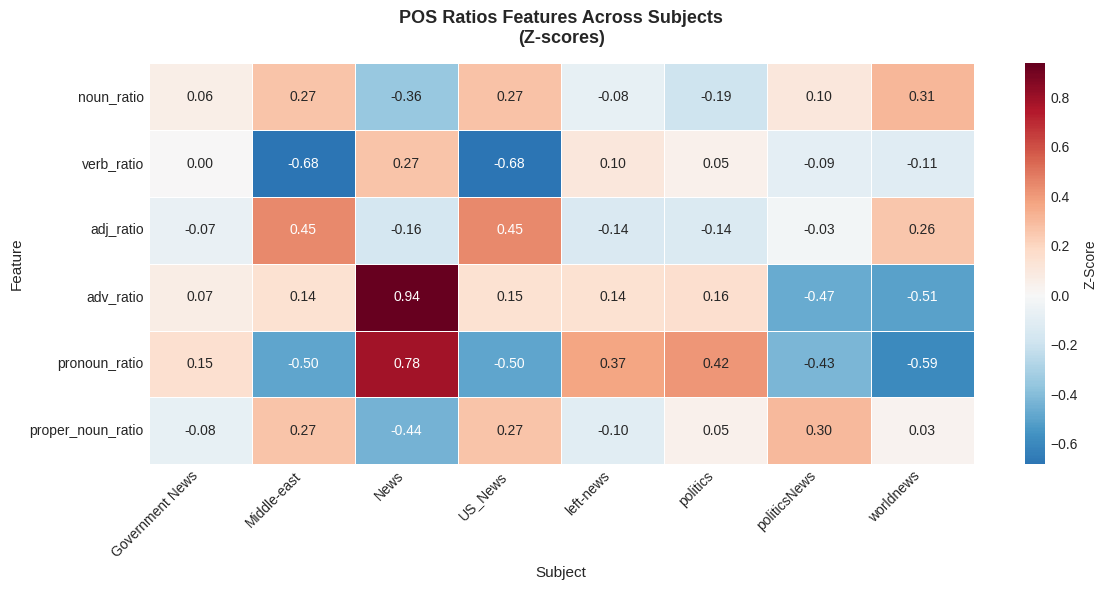

Saved: heatmap_pos_ratios.png


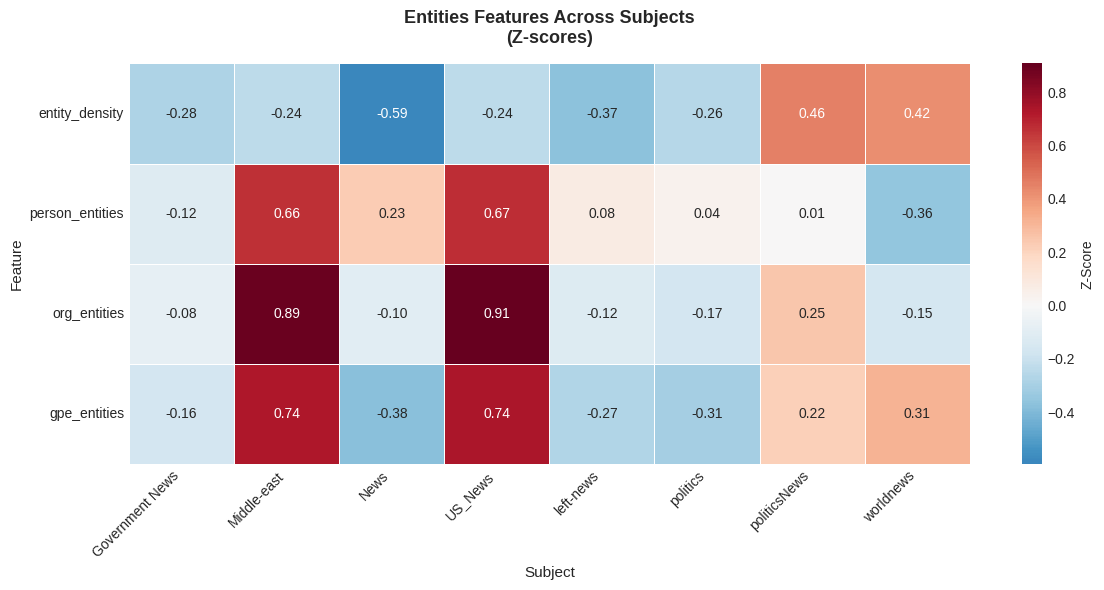

Saved: heatmap_entities.png


In [24]:
# Create category-specific heatmaps
for category, features in feature_categories.items():
    available_features = [f for f in features if f in z_scores_filtered.columns]
    
    if len(available_features) < 2:
        continue
    
    plt.figure(figsize=(12, max(6, len(available_features) * 0.5)))
    sns.heatmap(
        z_scores_filtered[available_features].T,
        cmap='RdBu_r',
        center=0,
        annot=True,
        fmt='.2f',
        cbar_kws={'label': 'Z-Score'},
        linewidths=0.5
    )
    plt.title(f'{category} Features Across Subjects\n(Z-scores)', 
              fontsize=13, fontweight='bold', pad=15)
    plt.xlabel('Subject', fontsize=11)
    plt.ylabel('Feature', fontsize=11)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    
    # Save
    filename = f'heatmap_{category.lower().replace(" ", "_")}.png'
    plt.savefig(output_dir / filename, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"Saved: {filename}")

### 11.4 Subject Profile Summary Tables

In [25]:
# Create a comprehensive table: For each subject, what are they "most prone to"?
subject_profiles = []

for subject in z_scores_filtered.index:
    subject_z = z_scores_filtered.loc[subject]
    
    # Find features where this subject is notably high (z > 1)
    high_features = subject_z[subject_z > 1.0].sort_values(ascending=False)
    
    # Find features where this subject is notably low (z < -1)
    low_features = subject_z[subject_z < -1.0].sort_values(ascending=True)
    
    profile = {
        'subject': subject,
        'n_articles': all_results[subject]['n_articles'],
        'high_features_count': len(high_features),
        'low_features_count': len(low_features),
        'top_3_high': ', '.join(high_features.head(3).index.tolist()),
        'top_3_low': ', '.join(low_features.head(3).index.tolist()),
    }
    
    subject_profiles.append(profile)

profiles_df = pd.DataFrame(subject_profiles)

print("\n" + "="*120)
print("SUBJECT PROFILES: WHAT EACH SUBJECT IS MOST PRONE TO")
print("="*120)
print("\nFeatures with |Z-score| > 1.0 (more than 1 standard deviation from mean)")
print(profiles_df.to_string(index=False))
print("\n" + "="*120)


SUBJECT PROFILES: WHAT EACH SUBJECT IS MOST PRONE TO

Features with |Z-score| > 1.0 (more than 1 standard deviation from mean)
        subject  n_articles  high_features_count  low_features_count                     top_3_high top_3_low
Government News        1570                    0                   0                                         
    Middle-east         778                    2                   0         char_count, word_count          
           News        9050                    0                   0                                         
        US_News         783                    3                   0 char_count, word_count, commas          
      left-news        4459                    0                   0                                         
       politics        6841                    0                   0                                         
   politicsNews       11272                    0                   0                                  

### 11.5 Save Cross-Subject Analysis Results

In [27]:
# Save all analysis results
cross_subject_dir = output_dir / 'cross_subject_analysis'
cross_subject_dir.mkdir(exist_ok=True)

# 1. Save z-scores
z_scores_filtered.to_csv(cross_subject_dir / 'feature_zscores.csv')
print(f"Saved: feature_zscores.csv")

# 2. Save feature means by subject
feature_means_by_subject.to_csv(cross_subject_dir / 'feature_means_by_subject.csv')
print(f"Saved: feature_means_by_subject.csv")

# 3. Save distinctive features per subject
for subject, df in subject_distinctive_features.items():
    filename = f'{subject}_distinctive_features.csv'
    df.to_csv(cross_subject_dir / filename, index=False)
    print(f"Saved: {filename}")

# 4. Save feature rankings by category
for category, df in feature_rankings.items():
    filename = f'ranking_{category.lower().replace(" ", "_")}.csv'
    df.to_csv(cross_subject_dir / filename, index=False)
    print(f"Saved: {filename}")

# 5. Save subject profiles
profiles_df.to_csv(cross_subject_dir / 'subject_profiles.csv', index=False)
print(f"Saved: subject_profiles.csv")

# 6. Create a comprehensive Excel file with all tables
with pd.ExcelWriter(cross_subject_dir / 'cross_subject_analysis_complete.xlsx', engine='openpyxl') as writer:
    z_scores_filtered.to_excel(writer, sheet_name='Z-Scores')
    feature_means_by_subject.to_excel(writer, sheet_name='Feature Means')
    profiles_df.to_excel(writer, sheet_name='Subject Profiles', index=False)
    
    for category, df in feature_rankings.items():
        sheet_name = category[:31]  # Excel sheet name limit
        df.to_excel(writer, sheet_name=sheet_name, index=False)
    
    for subject, df in subject_distinctive_features.items():
        sheet_name = subject[:31]
        df.to_excel(writer, sheet_name=sheet_name, index=False)

print(f"\nSaved: cross_subject_analysis_complete.xlsx")
print(f"\nAll results saved to: {cross_subject_dir}")
print(f"\nThe Excel file contains all tables in separate sheets for easy exploration!")

Saved: feature_zscores.csv
Saved: feature_means_by_subject.csv
Saved: Government News_distinctive_features.csv
Saved: Middle-east_distinctive_features.csv
Saved: News_distinctive_features.csv
Saved: US_News_distinctive_features.csv
Saved: left-news_distinctive_features.csv
Saved: politics_distinctive_features.csv
Saved: politicsNews_distinctive_features.csv
Saved: worldnews_distinctive_features.csv
Saved: ranking_readability.csv
Saved: ranking_text_length.csv
Saved: ranking_lexical.csv
Saved: ranking_sentiment.csv
Saved: ranking_punctuation.csv
Saved: ranking_pos_ratios.csv
Saved: ranking_entities.csv
Saved: subject_profiles.csv

Saved: cross_subject_analysis_complete.xlsx

All results saved to: ../results/subject_analysis/cross_subject_analysis

The Excel file contains all tables in separate sheets for easy exploration!
